### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com 


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']


In [2]:
from datetime import datetime, timedelta
import os
import shutil
import yaml
import sqlite3
import json
from collections import Counter
import uuid
from typing import TypedDict, Annotated
import subprocess
import requests
import re

import operator
import pickle

import langchain
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import (ChatPromptTemplate, MessagesPlaceholder, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver

from langchain_core.output_parsers import SimpleJsonOutputParser, JsonOutputParser, StrOutputParser

from langgraph.graph import StateGraph, START, END

from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

import numpy as np
import pandas as pd
import umap

import sklearn
from sklearn.cluster import DBSCAN

import bs4
from urllib.parse import urljoin, urlparse

import multiprocessing
import asyncio
import aiohttp

from IPython.display import HTML, Image, Markdown, display
import markdown

import pyperclip
import shlex

import openai
from openai import OpenAI

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

import pdb

import dotenv
VERBOSE=1
from ainb_const import (DOWNLOAD_DIR, PAGES_DIR,
                        MODEL, LOWCOST_MODEL, HIGHCOST_MODEL, CANONICAL_TOPICS,
                        SOURCECONFIG, FILTER_PROMPT, TOPIC_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT, FINAL_SUMMARY_PROMPT, 
                        TOP_CATEGORIES_PROMPT, TOPIC_REWRITE_PROMPT, REWRITE_PROMPT,
                        MAX_INPUT_TOKENS, MAX_OUTPUT_TOKENS, MAX_RETRIES, TEMPERATURE, SQLITE_DB,
                        HOSTNAME_SKIPLIST, SITE_NAME_SKIPLIST, TOPSOURCES,
                        SCREENSHOT_DIR, sleeptime

                       )
from ainb_utilities import (log, delete_files, filter_unseen_urls_db, insert_article,
                            nearest_neighbor_sort, agglomerative_cluster_sort, traveling_salesman_sort_scipy,
                            unicode_to_ascii, send_gmail)
from ainb_webscrape import (get_driver, quit_drivers, launch_drivers, get_file, get_url, parse_file,
                            get_og_tags, get_path_from_url, trimmed_href, process_source_queue_factory,
                            process_url_queue_factory, get_google_news_redirects)
from ainb_llm import (paginate_df, process_pages, fetch_pages, fetch_openai, fetch_all_summaries,
                      fetch_openai_summary, count_tokens, trunc_tokens, 
                      categorize_headline, categorize_df, clean_topics,
                      get_site_name, fetch_missing_site_names)


import asyncio
# need this to run async in jupyter since it already has an asyncio event loop running
import nest_asyncio
nest_asyncio.apply()


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")


Python            3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:26:25) [Clang 17.0.6 ]
LangChain         0.3.7
OpenAI            1.54.4
trafilatura       1.12.2
numpy             1.26.4
pandas            2.2.3
sklearn           1.5.2
umap              0.5.7


# Test LLM calling

In [4]:
# a basic LLM call with langchain
model = ChatOpenAI(model=MODEL)

model.invoke([
    SystemMessage(content="Translate the following from English into Italian"),
    HumanMessage(content='Listen to me. You are beautiful. You are perfect and I love you.'),
])


2024-11-18 08:57:38,562 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AIMessage(content='Ascoltami. Sei bellissima. Sei perfetta e ti amo.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 34, 'total_tokens': 50, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'chatgpt-4o-latest', 'system_fingerprint': 'fp_e9e8eff3a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-af18774e-c09a-45da-a2e9-3bb8a3d38306-0', usage_metadata={'input_tokens': 34, 'output_tokens': 16, 'total_tokens': 50, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [ ]:
# use a langchain template
system_template = "Translate the following into {language}:"
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)
parser = StrOutputParser()
chain = prompt_template | model | parser
chain.invoke({"language": "italian", "text": "hi"})


In [ ]:
# time multiple templates (single-threaded)
prompt_inputs = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

system_template = 'Translate the following into {language}:'
user_template = 'Listen to me. You are {adjective1}. You are {adjective2} and I love you.'

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template),
     ("user", user_template)]
)

parser = StrOutputParser()

chain = prompt_template | model | parser

start_time = datetime.now()
for tpl in prompt_inputs:
    response = ""
    # stream tokens as they are generated
    for r in chain.stream(tpl):
        print(r, end="")
        response += r
end_time = datetime.now()

difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")


In [ ]:
# same but send all at once using asyncio

async def async_langchain(chain, input_dict):
    response = await chain.ainvoke(input_dict)
    return response


prompt_templates = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

start_time = datetime.now()
tasks = []
for d in prompt_templates:
    task = asyncio.create_task(async_langchain(chain, d))
    tasks.append(task)
responses = await asyncio.gather(*tasks)
end_time = datetime.now()


difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")
print("\n".join(responses))


In [ ]:
# test o1-preview, note temperature, system prompt not supported
# client = OpenAI()
# response = client.chat.completions.create(
#     model="o1-preview",
#     messages=[
#         {
#             "role": "user",
#             "content": "Write a Python script that takes a matrix represented as a string with format '[1,2],[3,4],[5,6]' and prints the transpose in the same format."
#         }
#     ]
# )
# print(response.choices[0].message.content)


# Functions for state graph
- Each takes a state dict and returns updated state dict
- We will use these later to construct a LangGraph agent workflow

In [5]:
DEBUG = False
N_BROWSERS = 4
MAX_EDITS = 2
before_date = None
# before_date = '2024-10-19 15:00:00'
do_download = True


In [6]:
# class to maintain state within graph
# import pydantic

class AgentState(TypedDict):
    AIdf: list[dict]                    #  the current working set of headlines (pandas dataframe not supported)
    before_date: str                    #  ignore stories before this date for deduplication (force reprocess since)
    do_download: bool                   #  if False use existing files, else download from sources
    sources: dict                       #  sources to scrap
    sources_reverse: dict[str, str]     #  map file names to sources
    bullets: list[str]                  #  bullet points for summary email
    summary: str                        #  final summary
    cluster_topics: list[str]           #  list of cluster topics
    topics_str: str                     #  edited topics
    n_edits: int                        #  count edit iterations so we don't keep editing forever
    edit_complete: bool                 #  edit will update if no more edits to make
    # message thread with OpenAI
    # messages: Annotated[list[AnyMessage], operator.add]


In [7]:
test_state = AgentState(
    {'AIdf': [{}],
    'before_date': before_date,
    'do_download': do_download,
    'sources': {},
    'sources_reverse': {},
    'bullets': '',
    'summary': '',
    'cluster_topics': [],
    'topics_str': '',
    'n_edits': 0,
    'edit_complete': False,
    }
)


In [8]:
# Initialize reading configurations from YAML file

def fn_initialize(state: AgentState) -> AgentState:
    """
    Initializes the agent state by loading source configurations from SOURCECONFIG (sources.yaml) .

    Args:
        state (AgentState): The current state of the agent.
        verbose (bool, optional): Whether to print verbose output. Defaults to False.

    Returns:
        AgentState: The updated state of the agent.

    Raises:
        yaml.YAMLError: If there is an error while loading the YAML file.

    """

    #  load sources to scrape from sources.yaml
    with open(SOURCECONFIG, "r") as stream:
        try:
            state['sources'] = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

    log(f"Initialized {len(state['sources'])} items in sources from {SOURCECONFIG}")

    # make a reverse dict to map file titles to source names
    state['sources_reverse'] = {}
    for k, v in state['sources'].items():
        log(f"{k} -> {v['url']} -> {v['title']}.html")
        v['sourcename'] = k
        # map filename (title) to source name
        state['sources_reverse'][v['title']] = k

    log(f"Initialized {len(state['sources_reverse'])} items in sources_reverse")

    return state


if DEBUG:
    test_state = fn_initialize(test_state)


In [9]:
# scrape sources with selenium and save local files in DOWNLOAD_DIR (htmldata)
def fn_download_sources(state: AgentState) -> AgentState:
    """
    Scrapes sources and saves HTML files.
    If state["do_download"] is True, deletes all files in DOWNLOAD_DIR (htmldata) and scrapes fresh copies.
    If state["do_download"] is False, uses existing files in DOWNLOAD_DIR.
    Uses state["sources"] for config info on sources to scrape
    For each source, saves the current filename to state["sources"][sourcename]['latest']

    Args:
        state (AgentState): The current state of the agent.
        do_delete (bool, optional): Whether to delete files in DOWNLOAD_DIR. Defaults to True.

    Returns:
        AgentState: The updated state of the agent.
    """

    if state.get("do_download"):
        # empty download directories
        delete_files(DOWNLOAD_DIR)
        delete_files(PAGES_DIR)

        # save each file specified from sources
        log(f"Saving HTML files using {N_BROWSERS} browsers")

        # Create a queue for multiprocessing and populate it
        queue = multiprocessing.Queue()
        for item in state.get("sources").values():
            queue.put(item)

        # Function to take the queue and pop entries off and process until none are left
        # lets you create an array of functions with different args
        callable = process_source_queue_factory(queue)

        saved_pages = launch_drivers(N_BROWSERS, callable)
        for sourcename, file in saved_pages:
            log(f"Downloaded {sourcename} to {file}")
            state['sources'][sourcename]['latest'] = file
        log(f"Saved {len(saved_pages)} HTML files")

    else:   # use existing files
        log(f"Web fetch disabled, using existing files in {DOWNLOAD_DIR}")
        # Get the current date
        datestr = datetime.now().strftime("%m_%d_%Y")
        files = [os.path.join(DOWNLOAD_DIR, file)
                 for file in os.listdir(DOWNLOAD_DIR)]
        # filter files with today's date ending in .html
        files = [
            file for file in files if datestr in file and file.endswith(".html")]
        log(f"Found {len(files)} previously downloaded files")
        for file in files:
            log(file)

        saved_pages = []
        for file in files:
            filename = os.path.basename(file)
            # locate date like '01_14_2024' in filename
            position = filename.find(" (" + datestr)
            basename = filename[:position]
            # match to source name
            sourcename = state.get("sources_reverse", {}).get(basename)
            if sourcename is None:
                log(f"Skipping {basename}, no sourcename metadata")
                continue
            state["sources"][sourcename]['latest'] = file

    return state

if DEBUG:
    test_state = fn_download_sources(test_state)


In [10]:
def fn_extract_urls(state: AgentState) -> AgentState:
    """
    Extracts news URLs from the latest HTML files matching the patterns defined in the state['sources'] configuration info.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted URLs stored in state['AIdf'].
    """
    # Parse news URLs and titles from downloaded HTML files
    log("Parsing html files")
    all_urls = []
    for sourcename, sourcedict in state['sources'].items():
        filename = sourcedict.get('latest')
        if not filename:
            log(f"no filename found for {sourcename}")
            continue

        log(sourcename + ' -> ' + filename)
        links = parse_file(state['sources'][sourcename])
        log(f"{len(links)} links found")
        all_urls.extend(links)

    log(f"Saved {len(all_urls)} links")

    # make a pandas dataframe of all the links found
    AIdf = (
        pd.DataFrame(all_urls)
        .groupby("url")
        .first()
        .reset_index()
        .sort_values("src")[["src", "title", "url"]]
        .reset_index(drop=True)
        .reset_index(drop=False)
        .rename(columns={"index": "id"})
    )
    state['AIdf'] = AIdf.to_dict(orient='records')

    return state


if DEBUG:
    test_state = fn_extract_urls(test_state)

    # s/b 17 but if some like bloomberg" or wsj are missing, maybe got a robot block
    # if so, download missing ones manually and then re-run fn_extract_urls
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])


In [11]:
# get AI news via newscatcher
# https://docs.newscatcherapi.com/api-docs/endpoints/search-news

newscatcher_sources = ['247wallst.com',
 '9to5mac.com',
 'androidauthority.com',
 'androidcentral.com',
 'androidheadlines.com',
 'appleinsider.com',
 'benzinga.com',
 'cnet.com',
 'cnn.com',
 'digitaltrends.com',
 'engadget.com',
 'fastcompany.com',
 'finextra.com',
 'fintechnews.sg',
 'fonearena.com',
 'ft.com',
 'gadgets360.com',
 'geekwire.com',
 'gizchina.com',
 'gizmochina.com',
 'gizmodo.com',
 'gsmarena.com',
 'hackernoon.com',
 'howtogeek.com',
 'ibtimes.co.uk',
 'itwire.com',
 'lifehacker.com',
 'macrumors.com',
 'mashable.com',
#  'medium.com',
 'mobileworldlive.com',
 'msn.com',
 'nypost.com',
 'phonearena.com',
 'phys.org',
 'popsci.com',
 'scmp.com',
 'sify.com',
 'siliconangle.com',
 'siliconera.com',
 'siliconrepublic.com',
 'slashdot.org',
 'slashgear.com',
 'statnews.com',
 'tech.co',
 'techcrunch.com',
 'techdirt.com',
 'technode.com',
 'technologyreview.com',
 'techopedia.com',
 'techradar.com',
 'techraptor.net',
 'techtimes.com',
 'techxplore.com',
 'telecomtalk.info',
 'thecut.com',
 'thedrum.com',
 'thehill.com',
 'theregister.com',
 'theverge.com',
 'thurrott.com',
 'tipranks.com',
 'tweaktown.com',
 'videocardz.com',
 'washingtonpost.com',
 'wccftech.com',
 'wired.com',
 'xda-developers.com',
 'yahoo.com',
 'zdnet.com']

def fn_extract_newscatcher(state: AgentState) -> AgentState:
    
    q = 'Artificial Intelligence'
    page_size = 100
    log(f"Fetching top {page_size} stories matching {q} from Newscatcher")
    base_url = "https://api.newscatcherapi.com/v2/search"
    time_24h_ago = datetime.now() - timedelta(hours=24)

    # Put API key in headers 
    headers = {'x-api-key': os.getenv('NEWSCATCHER_API_KEY')}

    # Define search parameters
    params = {
        'q': q,
        'lang': 'en',
        'sources': ','.join(newscatcher_sources),
        'from': time_24h_ago.strftime('%Y-%m-%d %H:%M:%S'),
        'to': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'page_size': page_size, # by default should be most highly relevant to the search
        'page': 1
        }

    # Make API call with headers and params
    response = requests.get(base_url, headers=headers, params=params)

    # Encode received results
    results = json.loads(response.text.encode())
    if response.status_code != 200:
        print('ERROR: API call failed.')
        print(results)
        
    # merge into existing df
    newscatcher_df = pd.DataFrame(results['articles'])[['title', 'link']]
    newscatcher_df['src']='Newscatcher'
    newscatcher_df = newscatcher_df.rename(columns={'link': 'url'})
#     display(newscatcher_df.head())
    AIdf = pd.DataFrame(state['AIdf'])
#     display(AIdf.head())
    
    max_id = AIdf['id'].max()
    # add id column to newscatcher_df
    newscatcher_df['id'] = range(max_id + 1, max_id + 1 + len(newscatcher_df))
    AIdf = pd.concat([AIdf, newscatcher_df], ignore_index=True)
    state['AIdf'] = AIdf.to_dict(orient='records')
    return state
    

if DEBUG:
    test_state = fn_extract_newscatcher(test_state)
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    

In [12]:
# some debugging stuff
# zdf = pd.DataFrame(test_state["AIdf"])
# zdf.loc[zdf["src"]=='Techmeme']

# connection = sqlite3.connect('articles.db')
# xdf = pd.read_sql_query("SELECT * FROM news_articles", connection)
# connection.close()

# zdf.loc[zdf["title"].str.startswith("NHTSA")] 
# xdf.loc[xdf["title"].str.startswith("NHTSA")] 

# pd.set_option('display.max_rows', 300)  # Ensure up to 300 rows are shown

# xdf.loc[xdf['isAI']> 0].groupby('actual_src') \
#     .count() \
#     .reset_index()[['actual_src', 'id']] \
#     .sort_values('id', ascending=False) \
#     .head(300)


In [13]:
# sqlite schema to store previously processed 
# CREATE TABLE news_articles (
#     id INTEGER PRIMARY KEY,
#     src TEXT,
#     title TEXT,
#     url TEXT UNIQUE,
#     isAI BOOLEAN,
#     article_date DATE
# , timestamp DATETIME, actual_url TEXT, actual_src TEXT);
#
# CREATE TABLE sites (
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     hostname TEXT UNIQUE NOT NULL,
#     site_name TEXT NOT NULL
# );



In [14]:
# filter and clean URLs for new AI stories

def fn_filter_urls(state: AgentState) -> AgentState:
    """
    Filters the URLs in state["AIdf"] to include only those that have not been previously seen,
    and are related to AI according to the response from a ChatGPT prompt.

    Args:
        state (AgentState): The current state of the agent.
        before_date (str, optional): The date before which the URLs should be filtered. Defaults to "".

    Returns:


        AgentState: The updated state of the agent with the filtered URLs stored in state["AIdf"].

    """
    # filter to URL not previously seen
    AIdf = pd.DataFrame(state['AIdf'])

    AIdf = filter_unseen_urls_db(AIdf, before_date=state.get("before_date"))

    if len(AIdf) == 0:
        log("No new URLs, returning")
        return state

    # dedupe identical headlines
    # filter similar titles differing by type of quote or something
    AIdf['title'] = AIdf['title'].apply(unicode_to_ascii)
    AIdf['title_clean'] = AIdf['title'].map(lambda s: "".join(s.split()))
    AIdf = AIdf.sort_values("src") \
        .groupby("title_clean") \
        .first() \
        .reset_index(drop=True) \
        .drop(columns=['id']) \
        .reset_index() \
        .rename(columns={'index': 'id'})
    log(f"Found {len(AIdf)} unique new headlines")

    # structured response format
    json_schema = {
        "name": "json_schema",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "isai_array": {
                    "type": "array",
                    "items": {
                        "type": "object",
                                "properties": {
                                    "id": {
                                        "type": "number"
                                    },
                                    "isAI": {
                                        "type": "boolean"
                                    }
                                },
                        "required": ["id", "isAI"],
                        "additionalProperties": False
                    }
                }
            },
            "required": ["isai_array"],
            "additionalProperties": False
        }
    }

    # filter AI-related headlines using a prompt
    pages = paginate_df(AIdf)
    enriched_urls = asyncio.run(fetch_pages(pages, prompt=FILTER_PROMPT, json_schema=json_schema))
    filter_df = pd.DataFrame(enriched_urls)
    
    try:  # for idempotency
        AIdf = AIdf.drop(columns=['isAI'])
    except:
        pass

    # merge returned df with isAI column into original df on id column
    AIdf = pd.merge(AIdf, filter_df, on="id", how="outer")
    log(AIdf.columns)
    # set hostname based on actualurl
    AIdf['actual_url'] = AIdf['url']    # ideally resolve redirects but Google News blocks
    AIdf['hostname']=AIdf['actual_url'].apply(lambda url: urlparse(url).netloc)

    # update SQLite database with all seen URLs (we are doing this using url and ignoring redirects)
    log(f"Inserting {len(AIdf)} URLs into {SQLITE_DB}")
    conn = sqlite3.connect(SQLITE_DB)
    cursor = conn.cursor()
    for row in AIdf.itertuples():
        insert_article(conn, cursor, row.src, row.hostname, row.title,
                       row.url, row.actual_url, row.isAI, datetime.now().date())

    # keep headlines that are related to AI
    AIdf = AIdf.loc[AIdf["isAI"]==1] \
        .reset_index(drop=True)  \
        .reset_index()  \
        .drop(columns=["id"])  \
        .rename(columns={'index': 'id'})

    log(f"Found {len(AIdf)} AI headlines")

    # update actual URLs for Google News redirects
    # I think Google changed something so this no longer works, instead of a 301 redirct
    # get a javascript page that redirects. Also tomorrow we might see different URLs for same stories
    # AIdf = get_google_news_redirects(AIdf)

    conn = sqlite3.connect('articles.db')
    query = "select * from sites"
    sites_df = pd.read_sql_query(query, conn)
    sites_dict = {row.hostname:row.site_name for row in sites_df.itertuples()}
    conn.close()

    # get clean site_name
    AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))

    # if any missing clean site names, populate them using OpenAI
    missing_site_names =  len(AIdf.loc[AIdf['site_name']==""])
    if missing_site_names:
        log(f"Asking OpenAI for {missing_site_names} missing site names")
        responses = asyncio.run(fetch_missing_site_names(AIdf))
        # update site_dict from responses
        new_urls = []
        for r in responses:
            if r['url'].startswith('https://'):
                r['url'] = r['url'][8:]
            new_urls.append(r['url'])
            sites_dict[r['url']] = r['site_name']
            log(f"Looked up {r['url']} -> {r['site_name']}")
        # update sites table with new names
        for url in new_urls:
            sqlstr = "INSERT OR IGNORE INTO sites (hostname, site_name) VALUES (?, ?);"
            log(f"Updated {url} -> {sites_dict[url]}")
            conn.execute(sqlstr, (url, sites_dict[url]))
            conn.commit()
        # reapply to AIdf with updated sites
        AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))
    else:
        log("No missing site names")
  
    # drop banned slop sites

    AIdf = AIdf.loc[~AIdf["hostname"].str.lower().isin(HOSTNAME_SKIPLIST)]
    AIdf = AIdf.loc[~AIdf["site_name"].str.lower().isin(SITE_NAME_SKIPLIST)]
    
    state["AIdf"] = AIdf.to_dict(orient='records')
    return state


if DEBUG:
    test_state = fn_filter_urls(test_state)
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    display(list(pd.DataFrame(test_state["AIdf"]).columns))



In [15]:
# for row in pd.DataFrame(test_state["AIdf"]).itertuples():
#     display(Markdown(f"[{row.id}. {row.title} - {row.src}]({row.url})"))


In [16]:
# Function for topic extraction
# TODO: could send more prompts to gpt-4o-mini and not hit rate limits
def clean_topics(row, lcategories):
    """
    Cleans the extracted_topics and assigned_topics by removing certain common topics and combining them into a single list.

    Args:
        row (pandas.Series): The row containing the extracted_topics and assigned_topics.
        lcategories (set): The set of lowercase categories.

    Returns:
        list: The cleaned and combined list of topics.
    """
    extracted_topics = [x.title() for x in row.extracted_topics if x.lower() not in {"technology", "ai", "artificial intelligence"}]
    assigned_topics = [x.title() for x in row.assigned_topics if x.lower() in lcategories]
    combined = sorted(list(set(extracted_topics + assigned_topics)))
    combined = [s.replace("Ai", "AI") for s in combined]
    combined = [s.replace("Genai", "Gen AI") for s in combined]
    combined = [s.replace("Openai", "OpenAI") for s in combined]

    return combined


async def do_cat(AIdf, categories):
    """
    Sends a prompt to ChatGPT to select topics for the title for each row in AIdf
    which match the topics in categories.

    Args:
        AIdf (pandas.DataFrame): The DataFrame containing the headlines.
        categories (list): The list of topics to match with the headlines.

    Returns:
        dict: A dictionary where the keys are the row IDs and the values are lists
        of selected topics for each headline.

    """

    catdict = {}
    async with aiohttp.ClientSession() as session:
        for i, row in enumerate(AIdf.itertuples()):
            tasks = []
            log(f"Categorizing headline {row.id+1} of {len(AIdf)}")
            h = row.title
            log(h)
            for c in categories:
                task = asyncio.create_task(categorize_headline(h, c, session))
                tasks.append(task)
            responses = await asyncio.gather(*tasks)
            catdict[row.id] = [item for sublist in responses for item in sublist]
            log(str(catdict[row.id]))

    return catdict


def fn_topic_analysis(state: AgentState) -> AgentState:

    """
    Extracts and selects topics for each headline in the state['AIdf'] dataframe, scrubs them, and stores them back in the dataframe.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted and selected topics stored in state['AIdf'].
    """
    AIdf = pd.DataFrame(state['AIdf'])
    pages = paginate_df(AIdf)
    # apply topic extraction prompt to AI headlines
    log("start free-form topic extraction")
    json_schema = {
        "name": "extracted_topics",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "extracted_topics": {
                    "type": "array",
                    "items": {
                        "type": "object",
                        "properties": {
                            "id": {
                                "type": "number",
                            },
                            "topics": {
                                "type": "array",
                                "items": {
                                    "type": "string",
                                },
                            },
                        },
                        "required": ["id", "topics"],
                        "additionalProperties": False,
                    }
                }
            },
            "required": ["extracted_topics"],
            "additionalProperties": False,
        }
    }
    response = asyncio.run(fetch_pages(pages, prompt=TOPIC_PROMPT, json_schema=json_schema))
    topic_df = pd.DataFrame(response)

    topic_df = topic_df.rename(columns={'topics': 'extracted_topics'})
    log(f"{len(topic_df)} free-form topics extracted")
    all_topics = [item.lower() for row in topic_df.itertuples() for item in row.extracted_topics]
    item_counts = Counter(all_topics)
    filtered_topics = [item for item in item_counts if item_counts[item] >= 2 and item not in {'technology', 'ai', 'artificial intelligence'}]

    categories = sorted(CANONICAL_TOPICS)
    # use categories that are canonical or show up twice in freeform
    lcategories = set([c.lower() for c in categories] + [c.lower() for c in filtered_topics])
    # new topics
    log([c for c in filtered_topics if c not in categories])

    catdict = asyncio.run(categorize_headline(AIdf, categories=categories))
    topic_df['assigned_topics'] = topic_df['id'].apply(lambda id: catdict.get(id, ""))

#     pdb.set_trace()

    topic_df["topics"] = topic_df.apply(lambda t: clean_topics(t, lcategories), axis=1)
    topic_df["topic_str"] = topic_df.apply(lambda row: ", ".join(row.topics), axis=1)

    try: # for idempotency
        AIdf = AIdf.drop(columns=['topic_str', 'title_topic_str'])
    except:
        pass

    AIdf = pd.merge(AIdf, topic_df[["id", "topic_str"]], on="id", how="outer")
    AIdf['title_topic_str'] = AIdf.apply(lambda row: f'{row.title} (Topics: {row.topic_str})', axis=1)

    state["AIdf"] = AIdf.to_dict(orient='records')
    return state

if DEBUG:
    test_state = fn_topic_analysis(test_state)


In [17]:
async def write_topic_name(topic_list_str, max_retries=3, model=LOWCOST_MODEL):
    """
    Generates a name for a cluster based on a list of headline topics.

    Parameters:
    session (aiohttp.ClientSession): The client session for making async HTTP requests.
    topic_list_str (str): A string containing the list of headline topics.
    max_retries (int, optional): The maximum number of retries in case of an error. Defaults to 3.
    model (str, optional): The model to use for generating the topic name. Defaults to LOWCOST_MODEL.

    Returns:
    dict: A dictionary containing the generated topic name.

    Example Usage:
    title_topic_str_list = "Headline 1 (Topic: Topic 1)\n\nHeadline 2 (Topic: Topic 2)"
    result = await write_topic_name(session, title_topic_str_list)
    print(result)

    Output:
    {"topic_title": "Generated Topic Name"}
    ```
    """
    TOPIC_WRITER_PROMPT = f"""
You are a topic writing assistant. I will provide a list of headlines with extracted topics in parentheses.
Your task is to propose a name for a topic that very simply, clearly and accurately captures all the provided
headlines in less than 7 words. You will output a JSON object with the key "topic_title".

Example Input:
In the latest issue of Caixins weekly magazine: CATL Bets on 'Skateboard Chassis' and Battery Swaps to Dispell Market Concerns (powered by AI) (Topics: Battery Swaps, Catl, China, Market Concerns, Skateboard Chassis)

AI, cheap EVs, future Chevy  the week (Topics: Chevy, Evs)

Electric Vehicles and AI: Driving the Consumer & World Forward (Topics: Consumer, Electric Vehicles, Technology)

Example Output:
{{"topic_title": "Electric Vehicles"}}

Task
Propose the name for the overall topic based on the following provided headlines and individual topics:

{topic_list_str}
"""

    for i in range(max_retries):
        try:
            messages=[
                      {"role": "user", "content": TOPIC_WRITER_PROMPT
                      }]

            payload = {"model":  model,
                       "response_format": {"type": "json_object"},
                       "messages": messages,
                       "temperature": 0
                       }
#             print(topic_list_str)

            async with aiohttp.ClientSession() as session:
                response = asyncio.run(fetch_openai(session, payload))
            response_dict = json.loads(response["choices"][0]["message"]["content"])
            log(response_dict)
            
            return response_dict
        except Exception as exc:
            log(f"Error: {exc}")

    return {}


def fn_topic_clusters(state: AgentState) -> AgentState:
    """
    Fetches embeddings for the headlines, creates clusters of similar articles using DBSCAN, and sorts
    using the clusters and a traveling salesman shortest traversal in embedding space.

    Parameters:
    state (AgentState): The state of the agent.

    Returns:
    AgentState: The updated state of the agent.

    """
    AIdf = pd.DataFrame(state['AIdf'])

    log(f"Fetching embeddings for {len(AIdf)} headlines")
    embedding_model = 'text-embedding-3-large'
    client = OpenAI()
    response = client.embeddings.create(input=AIdf['title_topic_str'].tolist(),
                                        model=embedding_model)
    embedding_df = pd.DataFrame([e.model_dump()['embedding'] for e in response.data])

    # greedy traveling salesman sort
    log(f"Sort with nearest_neighbor_sort sort")
    sorted_indices = nearest_neighbor_sort(embedding_df)
    AIdf['sort_order'] = sorted_indices

    # do dimensionality reduction on embedding_df and cluster analysis
    log(f"Load umap dimensionality reduction model")
    with open("reducer.pkl", 'rb') as file:
        # Load the model from the file
        reducer = pickle.load(file)
    log(f"Perform dimensionality reduction")
    reduced_data = reducer.transform(embedding_df)
    log(f"Cluster with DBSCAN")
    dbscan = DBSCAN(eps=0.4, min_samples=3)  # Adjust eps and min_samples as needed
    AIdf['cluster'] = dbscan.fit_predict(reduced_data)
    AIdf.loc[AIdf['cluster'] == -1, 'cluster'] = 999

    # sort first by clusters found by DBSCAN, then by semantic ordering
    AIdf = AIdf.sort_values(['cluster', 'sort_order']) \
        .reset_index(drop=True) \
        .reset_index() \
        .drop(columns=["id"]) \
        .rename(columns={'index': 'id'})

    # show clusters
    state["cluster_topics"] = []
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
        for i in range(30):
            try:
                tmpdf = AIdf.loc[AIdf['cluster']==i][["id", "title_topic_str"]]
                if len(tmpdf) ==0:
                    break
                display(tmpdf)
                title_topic_str_list = ("\n\n".join(tmpdf['title_topic_str'].to_list()))
                cluster_topic = asyncio.run(write_topic_name(title_topic_str_list))
                cluster_topic = cluster_topic['topic_title']
                state["cluster_topics"].append(cluster_topic)
                log(f"I dub this cluster: {cluster_topic}")
            except Exception as exc:
                log(exc)
    AIdf["cluster_name"] = AIdf['cluster'].apply(lambda i: state["cluster_topics"][i] 
                                                 if i < len(state["cluster_topics"]) 
                                                 else "")
    state["AIdf"] = AIdf.to_dict(orient='records')
    print(state["cluster_topics"])
    return state

# TODO: could add a quality rating for stories based on site reputation, length, complexity of story
# could then add the quality rating to the summaries and tell the prompt to favor high-quality stories
# could put summaries into vector store and retrieve stories by topic. but then you will have to deal
# with duplicates across categories, ask the prompt to dedupe

# def fn_topic_clusters(state: AgentState) -> AgentState:
#     "call async afn_topic_clusters on state"
#     state = asyncio.run(afn_topic_clusters(state))
#     return state


if DEBUG:
    test_state = fn_topic_clusters(test_state)


In [18]:
# scrape individual pages
def fn_download_pages(state: AgentState) -> AgentState:
    """
    Uses several Selenium browser sessions to download all the pages referenced in the
    state["AIdf"] DataFrame and store their pathnames.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the downloaded pages' pathnames stored in the `state["AIdf"]` DataFrame.
    """
    log("Queuing URLs for scraping")
    AIdf = pd.DataFrame(state['AIdf'])
    queue = multiprocessing.Queue()

    count = 0
    for row in AIdf.itertuples():
#         if row.cluster < 999:
        queue.put((row.id, row.url, row.title))
        count +=1
    # scrape urls in queue asynchronously
    num_browsers = 4

    callable = process_url_queue_factory(queue)

    log(f"fetching {count} pages using {num_browsers} browsers")
    saved_pages = launch_drivers(num_browsers, callable)

    pages_df = pd.DataFrame(saved_pages)
    if len(pages_df):
        pages_df.columns = ['id', 'url', 'title', 'path']

        try: # for idempotency
            AIdf = AIdf.drop(columns=['path'])
        except:
            pass        
        AIdf = pd.merge(AIdf, pages_df[["id", "path"]], on='id', how="inner")
    state["AIdf"] = AIdf.to_dict(orient='records')
    return state


if DEBUG:
    test_state = fn_download_pages(test_state)



In [19]:
# summarize individual pages

def fn_summarize_pages(state: AgentState) -> AgentState:
    """
    Reads all the articles, summarizes each one using a ChatGPT prompt, and sends an email with the summaries.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent.

    """
    log("Starting summarize")
    AIdf = pd.DataFrame(state['AIdf'])
    responses = asyncio.run(fetch_all_summaries(AIdf))
    log(f"Received {len(responses)} summaries")
    response_dict = {}
    for i, response in responses:
        try:
            response_str = response["choices"][0]["message"]["content"]
            response_dict[i] = response_str
        except Exception as exc:
            print(exc)

    markdown_str = ''
    bullets = []

    for i, row in enumerate(AIdf.itertuples()):
        try:
            topics = []
            if row.cluster_name:
                topics.append(row.cluster_name)
            if row.topic_str:
                topics.append(row.topic_str)
            topic_str = ", ".join(topics)

            mdstr = f"[{i+1}. {row.title} - {row.site_name}]({row.actual_url})  \n\n {topic_str}  \n\n{response_dict[row.id]} \n\n"
            bullets.append(f"[{row.title} - {row.site_name}]({row.actual_url})\n\nTopics: {row.topic_str} \n\n{response_dict[row.id]}\n\n")
            display(Markdown(mdstr.replace("$","\\\\$")))
            markdown_str += mdstr
        except Exception as exc:
            print("Error:", exc)

    state['bullets'] = bullets
    # Convert Markdown to HTML
    html_str = markdown.markdown(markdown_str, extensions=['extra'])
    # save bullets
    with open('bullets.md', 'w') as f:
        f.write(markdown_str)
    # send email
    log("Sending bullet points email")
    subject = f'AI news bullets {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)

    return state


if DEBUG:
    test_state = fn_summarize_pages(test_state)



In [20]:
topic_schema = {
                "name": "topic_schema",
                "strict": True,
                "schema": {
                    "type": "object",
                    "properties": {
                        "topics": {
                            "type": "array",
                            "items": {
                                "type": "string",
                            }
                        }
                    },
                    "additionalProperties": False,
                    "required": ["topics"],
                }
            }



def topic_rewrite(client, 
                  model, 
                  prompt_template,
                  topics_str,
                  json_schema
                 ):
    client = OpenAI()
    response = client.chat.completions.create(
        model=model,
        response_format={
            "type": "json_schema",
            "json_schema": json_schema
        },
        messages=[{
            "role": "user",
            "content": prompt_template.format(topics_str=topics_str)
        }])
    response_str = response.choices[0].message.content
#     print(response_str)
    return response_str


def fn_propose_cats(state: AgentState) -> AgentState:
    # ask chatgpt for top categories
    log(f"Proposing categories using {MODEL}")

    model = ChatOpenAI(
        model=MODEL,
        temperature=0.3,
        model_kwargs={"response_format": {"type": "json_object"}}
    )

    chain = ChatPromptTemplate.from_template("{p}") | model | SimpleJsonOutputParser()
    response = chain.invoke({ "p": TOP_CATEGORIES_PROMPT + "\n\n".join(state.get("bullets", []))})
    suggested_categories = []
    for k, v in response.items():
        suggested_categories.extend(v)
    state["cluster_topics"] = list(set(state["cluster_topics"] + suggested_categories))
    state["cluster_topics"].sort()
    topics_str = "\n".join(state["cluster_topics"])
    log(f"Original topics:\n{topics_str}")
    # rewrite
    response_str = topic_rewrite(OpenAI(), 'gpt-4o', TOPIC_REWRITE_PROMPT, topics_str, topic_schema)
#     print(response_str)
    state["topics_str"] = "\n".join(sorted(json.loads(response_str)['topics']))
    log(f"Updated topics:\n{state['topics_str']}")
    return state


if DEBUG:
    test_state = fn_propose_cats(test_state)
    print("edit the following proposed topic list and update state['cluster_topics']:")
    print('"' + '",\n"'.join(test_state["cluster_topics"]) + '"')


In [21]:
def fn_compose_summary(state: AgentState) -> AgentState:
    log(f"Composing summary using {HIGHCOST_MODEL}")

    cat_str = state['topics_str']
    bullet_str = "\n~~~\n".join(state.get("bullets", []))
    client = OpenAI()
    response = client.chat.completions.create(
        model=HIGHCOST_MODEL,
        messages=[
            {
                "role": "user",
                "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            }
        ]
    )
#     print(response)
    
#     model = ChatOpenAI(
#         model=HIGHCOST_MODEL,
#         temperature=0.3,
#         model_kwargs={"response_format": {"type": "json_object"}}
#     )

#     chain = ChatPromptTemplate.from_template(FINAL_SUMMARY_PROMPT) | model | SimpleJsonOutputParser()
#     response = chain.invoke({ "cat_str": cat_str, "bullet_str": bullet_str})
#     print(response)
    state["summary"] = response.choices[0].message.content

    return state


if DEBUG:
    test_state = fn_compose_summary(test_state)
    display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [22]:
#post manually to o1-preview and grab response b/c I don't have API yet
# cat_str = "\n".join(test_state['cluster_topics'])
# bullet_str = "\n~~~\n".join(test_state["bullets"])
# final_summary_prompt = FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
# count_tokens(final_summary_prompt)
# # copy to clipboard to paste in o1-preview
# subprocess.run("pbcopy", universal_newlines=True, input=final_summary_prompt)
# print(final_summary_prompt)


In [23]:
# test_state["summary"] = """
# """

# display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [24]:
def fn_rewrite_summary(state: AgentState) -> AgentState:

#     model = ChatOpenAI(
#         model=HIGHCOST_MODEL,
#         temperature=0.3,
#         model_kwargs={"response_format": {"type": "json_object"}}
#     )

#     chain = ChatPromptTemplate.from_template(REWRITE_PROMPT) | model | SimpleJsonOutputParser()
#     response = chain.invoke({ "summary": state["summary"]})
    log(f"Rewriting summary using {HIGHCOST_MODEL}")

    client = OpenAI()
    response = client.chat.completions.create(
        model=HIGHCOST_MODEL,
        messages=[
            {
                "role": "user",
                "content": REWRITE_PROMPT.format(summary=state["summary"])
            }
        ]
    )
    response_str = response.choices[0].message.content
    state["n_edits"] += 1    
    if response_str.strip().lower().startswith('ok'):
        log("No edits made, edit complete")
        state["edit_complete"] = True
    else:
        state["summary"] = response_str
    return state


if DEBUG:
    test_state = fn_rewrite_summary(test_state)
    display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [25]:
# rewrite_prompt = (REWRITE_PROMPT.format(summary=test_state["summary"]))
# subprocess.run("pbcopy", universal_newlines=True, input=rewrite_prompt)
# print(rewrite_prompt)


In [26]:

# test_state["summary"] = """
# """

# if DEBUG:
#     display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [27]:
def fn_is_revision_complete(state: AgentState) -> str:
    """update edit_complete if MAX_EDITS exceeded"
    return "complete" if edit_complete else "incomplete"
    """

    if state["n_edits"] >= MAX_EDITS:
        log("Max edits reached")
        state["edit_complete"] = True


    return "complete" if state["edit_complete"] else "incomplete"


if DEBUG:
    test_state["edit_complete"] = fn_is_revision_complete(test_state)
    display(test_state["edit_complete"])


In [28]:
def fn_send_mail(state: AgentState) -> AgentState:

    log("Sending summary email")
    # Convert Markdown to HTML
    html_str = markdown.markdown(state['summary'], extensions=['extra'])
    # extract subject, match a top-level Markdown heading (starts with "# ")
    match = re.search(r"^# (.+)$", state["summary"], re.MULTILINE)
    
    # If a match is found, return the first captured group (the heading text)
    if match:
        subject = match.group(1).strip()
    else:
        subject = f'AI news summary {datetime.now().strftime("%H:%M:%S")}'
    log(f"Email subject {subject}")
    log(f"Email length {len(html_str)}")
        
    # send email
    send_gmail(subject, html_str)
    return state

if DEBUG:
    fn_send_mail(test_statestate)

# Define LangGraph agent state graph

In [29]:
class Agent:

    def __init__(self, state):
        
        self.state = state
        
        graph_builder = StateGraph(AgentState)
        graph_builder.add_node("initialize", self.initialize)
        graph_builder.add_node("download_sources", self.download_sources)
        graph_builder.add_node("extract_web_urls", self.extract_web_urls)
        graph_builder.add_node("extract_newscatcher_urls", self.extract_newscatcher_urls)
        graph_builder.add_node("filter_urls", self.filter_urls)
        graph_builder.add_node("topic_analysis", self.topic_analysis)
        graph_builder.add_node("topic_clusters", self.topic_clusters)
        graph_builder.add_node("download_pages", self.download_pages)
        graph_builder.add_node("summarize_pages", self.summarize_pages)
        graph_builder.add_node("propose_topics", self.propose_topics)
        graph_builder.add_node("compose_summary", self.compose_summary)
        graph_builder.add_node("rewrite_summary", self.rewrite_summary)
        graph_builder.add_node("send_mail", self.send_mail)

        graph_builder.add_edge(START, "initialize")
        graph_builder.add_edge("initialize", "download_sources")
        graph_builder.add_edge("download_sources", "extract_web_urls")
        graph_builder.add_edge("extract_web_urls", "extract_newscatcher_urls")
        graph_builder.add_edge("extract_newscatcher_urls", "filter_urls")
        graph_builder.add_edge("filter_urls", "topic_analysis")
        graph_builder.add_edge("topic_analysis", "topic_clusters")
        graph_builder.add_edge("topic_clusters", "download_pages")
        graph_builder.add_edge("download_pages", "summarize_pages")
        graph_builder.add_edge("summarize_pages", "propose_topics")
        graph_builder.add_edge("propose_topics", "compose_summary")
        graph_builder.add_edge("compose_summary", "rewrite_summary")
        graph_builder.add_conditional_edges("rewrite_summary",
                                            self.is_revision_complete,
                                            {"incomplete": "rewrite_summary",
                                             "complete": "send_mail",
                                            })
        graph_builder.add_edge("send_mail", END)

        # human in the loop should check web pages downloaded ok, and edit proposed categories 
#         self.conn = sqlite3.connect('lg_checkpointer.db')
#         self.checkpointer = SqliteSaver(conn=self.conn)
        self.checkpointer = MemorySaver()
        graph = graph_builder.compile(checkpointer=self.checkpointer,
                                      interrupt_before=["filter_urls", "compose_summary",])
        self.graph = graph


    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def download_sources(self, state: AgentState) -> AgentState:
        self.state = fn_download_sources(state)
        return self.state

    def extract_web_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_newscatcher(state)
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def topic_analysis(self, state: AgentState) -> AgentState:
        self.state = fn_topic_analysis(state)
        return self.state

    def topic_clusters(self, state: AgentState) -> AgentState:
        self.state = fn_topic_clusters(state)
        return self.state

    def download_pages(self, state: AgentState) -> AgentState:
        self.state = fn_download_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def propose_topics(self, state: AgentState) -> AgentState:
        self.state = fn_propose_cats(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state

    def rewrite_summary(self, state: AgentState) -> AgentState:
        self.state = fn_rewrite_summary(state)
        return self.state

    def is_revision_complete(self, state: AgentState) -> str:
        return fn_is_revision_complete(state)

    def send_mail(self, state: AgentState) -> AgentState:
        self.state = fn_send_mail(state)
        return self.state
    
    def run(self, state, config):
        # The config is the **second positional argument** to stream() or invoke()!
        events = self.graph.stream(state, config, stream_mode="values"
        )
        
        for event in events:
            try:
                if event.get('summary'):
                    display(Markdown(event.get('summary').replace("$","\\\\$")))
                elif event.get('bullets'):
                    display(Markdown("\n\n".join(event.get('bullets')).replace("$","\\\\$")))
                elif event.get('cluster_topics'):
                    display(Markdown("\n\n".join(event.get('cluster_topics'))))
                elif event.get('AIdf'):
                    display(pd.DataFrame(event.get('AIdf')).groupby("src").count()[['id']])
                elif event.get('sources'):
                    print([k for k in event.get('sources').keys()])
            except Exception as exc: 
                print(exc)
                
        return self.state

 

# Instantiate agent and show flowchart

2024-11-18 08:57:58,827 - AInewsbot - INFO - Initializing with before_date=, do_download=True, thread_id=c93aad53de8146ab99c9987cf4850048


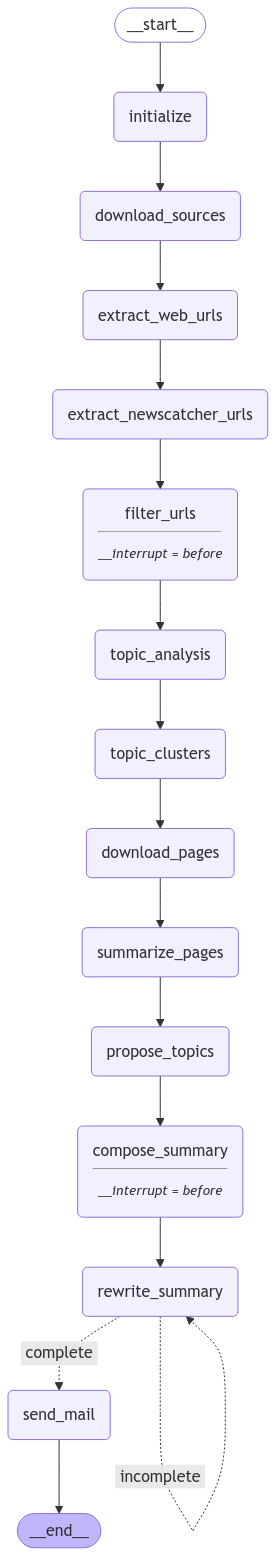

In [30]:
do_download = True
before_date = ''
# before_date = '2024-11-11 017:00:00'
# use everything since this date even if already seen
# like if you want to rerun it for any reason after sqlite updated

# initial state
state = AgentState(
    {'AIdf': [{}],
    'before_date': before_date,
    'do_download': do_download,
    'sources': {},
    'sources_reverse': {},
    'bullets': '',
    'summary': '',
    'cluster_topics': [],
    'topics_str': '',
    'n_edits': 0,
    'edit_complete': False,
    }
)

# Configuration with thread ID for checkpointing
# Generate a random UUID
thread_id = uuid.uuid4().hex
config = {"configurable": {"thread_id": thread_id}}

log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")
lg_agent = Agent(state)
display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


# Run each step individually

In [31]:
# download and extract, human in the loop checks all sources downloaded OK
state = lg_agent.initialize(state)
state = lg_agent.download_sources(state)
state = lg_agent.extract_web_urls(state)
state = lg_agent.extract_newscatcher_urls(state)
# s/b 18 check all downloaded, if any got hit by a bot block then download manually
print(len(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]))
pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]


2024-11-18 08:58:00,874 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2024-11-18 08:58:00,875 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-11-18 08:58:00,875 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2024-11-18 08:58:00,876 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2024-11-18 08:58:00,876 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2024-11-18 08:58:00,877 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2024-11-18 08:58:00,877 - AInewsbot - INFO - 

2024-11-18 08:59:41,254 - AInewsbot - INFO - get_files(Bloomberg Technology) - Saving Bloomberg Technology (11_18_2024 08_59_41 AM).html as utf-8
2024-11-18 08:59:41,255 - AInewsbot - INFO - Processing HackerNoon
2024-11-18 08:59:41,256 - AInewsbot - INFO - get_files(HackerNoon) - starting get_files https://hackernoon.com/
2024-11-18 08:59:48,493 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:192:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:510:5
dom.find/</<@chrome://remote/content/shared/DOM.sys.mjs:136:16

2024-11-18 08:59:48,494 - AInewsbot - INFO - get_files(Hacker News Page 1) - Saving Hacker News Page 1 (11_18_202

2024-11-18 09:00:29,293 - AInewsbot - INFO - get_files(WSJ Technology) - Saving WSJ Technology (11_18_2024 09_00_29 AM).html as utf-8
2024-11-18 09:00:29,295 - AInewsbot - INFO - Quit webdriver
2024-11-18 09:00:35,753 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:192:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:510:5
dom.find/</<@chrome://remote/content/shared/DOM.sys.mjs:136:16

2024-11-18 09:00:35,753 - AInewsbot - INFO - get_files(Washington Post Technology) - Saving Washington Post Technology (11_18_2024 09_00_35 AM).html as utf-8
2024-11-18 09:00:35,754 - AInewsbot - INFO - Quit webdriver
2024-11-18 09:00:38,183 - 

2024-11-18 09:01:02,194 - AInewsbot - INFO - parse_file - found 305 raw links
2024-11-18 09:01:02,198 - AInewsbot - INFO - parse_file - found 34 filtered links
2024-11-18 09:01:02,198 - AInewsbot - INFO - 34 links found
2024-11-18 09:01:02,198 - AInewsbot - INFO - VentureBeat -> htmldata/VentureBeat AI (11_18_2024 09_00_22 AM).html
2024-11-18 09:01:02,216 - AInewsbot - INFO - parse_file - found 329 raw links
2024-11-18 09:01:02,220 - AInewsbot - INFO - parse_file - found 43 filtered links
2024-11-18 09:01:02,220 - AInewsbot - INFO - 43 links found
2024-11-18 09:01:02,220 - AInewsbot - INFO - WSJ Tech -> htmldata/WSJ Technology (11_18_2024 09_00_29 AM).html
2024-11-18 09:01:02,252 - AInewsbot - INFO - parse_file - found 501 raw links
2024-11-18 09:01:02,258 - AInewsbot - INFO - parse_file - found 45 filtered links
2024-11-18 09:01:02,259 - AInewsbot - INFO - 45 links found
2024-11-18 09:01:02,259 - AInewsbot - INFO - WaPo Tech -> htmldata/Washington Post Technology (11_18_2024 09_00_35 

17


,id
src,
Ars Technica,31
Bloomberg Tech,13
Business Insider,50
FT Tech,56
Feedly AI,36
Hacker News,26
Hacker News 2,23
HackerNoon,97
NYT Tech,19


In [32]:
state = lg_agent.filter_urls(state)
pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]

# do topic analysis, identify good topics
state = lg_agent.topic_analysis(state)
state = lg_agent.topic_clusters(state)

# download and summarize pages
state = lg_agent.download_pages(state)

state = lg_agent.summarize_pages(state)
# free-form extract topics from summarize, combine with clusters, propose clean topics
state = lg_agent.propose_topics(state)
print(state["topics_str"])
# compose using o1-preview and rewrite summary 3 times
state = lg_agent.compose_summary(state)
display(Markdown(state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(state)=='complete':
        break
    state = lg_agent.rewrite_summary(state)
    display(Markdown(state["summary"].replace("$","\\\\$")))
state = lg_agent.send_mail(state)

2024-11-18 09:01:02,907 - AInewsbot - INFO - Querying SQLite with where_clause: 
2024-11-18 09:01:03,050 - AInewsbot - INFO - URLs in orig_df: 1064
2024-11-18 09:01:03,053 - AInewsbot - INFO - Existing URLs in DB: 182281
2024-11-18 09:01:03,178 - AInewsbot - INFO - New URLs in df filtered by URL: 345
2024-11-18 09:01:03,291 - AInewsbot - INFO - Existing src+title: 36
2024-11-18 09:01:03,292 - AInewsbot - INFO - New URLs in df filtered by src+title: 309
2024-11-18 09:01:03,305 - AInewsbot - INFO - Found 304 unique new headlines
2024-11-18 09:01:03,522 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-11-18 09:01:03,523 - AInewsbot - INFO - sent 50 items 
2024-11-18 09:01:03,524 - AInewsbot - INFO - sent 50 items 
2024-11-18 09:01:03,525 - AInewsbot - INFO - sent 50 items 
2024-11-18 09:01:03,526 - AInewsbot - INFO - sent 50 items 
2024-11-18 09:01:03,526 - AInewsbot - INFO - sent 50 items 
2024-11-18 09:01:03,526 - AInewsbot - INFO - sent 50 items 
2024-11-18 09:01:

2024-11-18 09:01:56,077 - AInewsbot - INFO - sent 29 items 
2024-11-18 09:01:58,223 - AInewsbot - INFO - got dict with 29 items 
2024-11-18 09:01:59,463 - AInewsbot - INFO - got dict with 50 items 
2024-11-18 09:01:59,465 - AInewsbot - INFO - Processed 79 responses.
2024-11-18 09:01:59,466 - AInewsbot - INFO - China, topic 12 of 100
2024-11-18 09:01:59,467 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-18 09:01:59,468 - AInewsbot - INFO - sent 50 items 
2024-11-18 09:01:59,469 - AInewsbot - INFO - sent 29 items 
2024-11-18 09:02:01,365 - AInewsbot - INFO - got dict with 29 items 
2024-11-18 09:02:03,457 - AInewsbot - INFO - got dict with 50 items 
2024-11-18 09:02:03,461 - AInewsbot - INFO - Processed 79 responses.
2024-11-18 09:02:03,462 - AInewsbot - INFO - Climate, topic 13 of 100
2024-11-18 09:02:03,463 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-18 09:02:03,465 - AInewsbot - INFO - sent 50 items 
2024-11-18 09:02:03,466 - AI

2024-11-18 09:02:57,532 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-18 09:02:57,533 - AInewsbot - INFO - sent 50 items 
2024-11-18 09:02:57,534 - AInewsbot - INFO - sent 29 items 
2024-11-18 09:02:59,775 - AInewsbot - INFO - got dict with 29 items 
2024-11-18 09:03:01,010 - AInewsbot - INFO - got dict with 50 items 
2024-11-18 09:03:01,011 - AInewsbot - INFO - Processed 79 responses.
2024-11-18 09:03:01,012 - AInewsbot - INFO - Ethics, topic 29 of 100
2024-11-18 09:03:01,013 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-18 09:03:01,014 - AInewsbot - INFO - sent 50 items 
2024-11-18 09:03:01,015 - AInewsbot - INFO - sent 29 items 
2024-11-18 09:03:03,520 - AInewsbot - INFO - got dict with 29 items 
2024-11-18 09:03:04,488 - AInewsbot - INFO - got dict with 50 items 
2024-11-18 09:03:04,492 - AInewsbot - INFO - Processed 79 responses.
2024-11-18 09:03:04,493 - AInewsbot - INFO - European Union, topic 30 of 100
2024-11-18 09:03:04,

2024-11-18 09:03:57,444 - AInewsbot - INFO - IPOs, topic 45 of 100
2024-11-18 09:03:57,445 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-18 09:03:57,446 - AInewsbot - INFO - sent 50 items 
2024-11-18 09:03:57,447 - AInewsbot - INFO - sent 29 items 
2024-11-18 09:04:00,221 - AInewsbot - INFO - got dict with 29 items 
2024-11-18 09:04:01,119 - AInewsbot - INFO - got dict with 50 items 
2024-11-18 09:04:01,121 - AInewsbot - INFO - Processed 79 responses.
2024-11-18 09:04:01,122 - AInewsbot - INFO - India, topic 46 of 100
2024-11-18 09:04:01,123 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-18 09:04:01,125 - AInewsbot - INFO - sent 50 items 
2024-11-18 09:04:01,126 - AInewsbot - INFO - sent 29 items 
2024-11-18 09:04:03,478 - AInewsbot - INFO - got dict with 29 items 
2024-11-18 09:04:05,114 - AInewsbot - INFO - got dict with 50 items 
2024-11-18 09:04:05,116 - AInewsbot - INFO - Processed 79 responses.
2024-11-18 09:04:05,117 - AInew

2024-11-18 09:04:59,470 - AInewsbot - INFO - got dict with 50 items 
2024-11-18 09:04:59,473 - AInewsbot - INFO - Processed 79 responses.
2024-11-18 09:04:59,473 - AInewsbot - INFO - Neuromorphic Computing, topic 62 of 100
2024-11-18 09:04:59,474 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-18 09:04:59,476 - AInewsbot - INFO - sent 50 items 
2024-11-18 09:04:59,477 - AInewsbot - INFO - sent 29 items 
2024-11-18 09:05:01,472 - AInewsbot - INFO - got dict with 29 items 
2024-11-18 09:05:03,094 - AInewsbot - INFO - got dict with 50 items 
2024-11-18 09:05:03,096 - AInewsbot - INFO - Processed 79 responses.
2024-11-18 09:05:03,097 - AInewsbot - INFO - Nuclear, topic 63 of 100
2024-11-18 09:05:03,098 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-18 09:05:03,099 - AInewsbot - INFO - sent 50 items 
2024-11-18 09:05:03,100 - AInewsbot - INFO - sent 29 items 
2024-11-18 09:05:05,020 - AInewsbot - INFO - got dict with 29 items 
2024-11-18 

2024-11-18 09:11:48,908 - AInewsbot - INFO - sent 50 items 
2024-11-18 09:11:48,909 - AInewsbot - INFO - sent 29 items 
2024-11-18 09:11:51,399 - AInewsbot - INFO - got dict with 29 items 
2024-11-18 09:11:52,384 - AInewsbot - INFO - got dict with 50 items 
2024-11-18 09:11:52,386 - AInewsbot - INFO - Processed 79 responses.
2024-11-18 09:11:52,387 - AInewsbot - INFO - Scams, topic 79 of 100
2024-11-18 09:11:52,388 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-18 09:11:52,389 - AInewsbot - INFO - sent 50 items 
2024-11-18 09:11:52,390 - AInewsbot - INFO - sent 29 items 
2024-11-18 09:11:55,356 - AInewsbot - INFO - got dict with 29 items 
2024-11-18 09:11:56,889 - AInewsbot - INFO - got dict with 50 items 
2024-11-18 09:11:56,892 - AInewsbot - INFO - Processed 79 responses.
2024-11-18 09:11:56,893 - AInewsbot - INFO - Science, topic 80 of 100
2024-11-18 09:11:56,894 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-18 09:11:56,895 - AI

2024-11-18 09:12:49,647 - AInewsbot - INFO - Transportation, topic 95 of 100
2024-11-18 09:12:49,648 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-18 09:12:49,649 - AInewsbot - INFO - sent 50 items 
2024-11-18 09:12:49,651 - AInewsbot - INFO - sent 29 items 
2024-11-18 09:12:52,120 - AInewsbot - INFO - got dict with 29 items 
2024-11-18 09:12:52,959 - AInewsbot - INFO - got dict with 50 items 
2024-11-18 09:12:52,961 - AInewsbot - INFO - Processed 79 responses.
2024-11-18 09:12:52,962 - AInewsbot - INFO - Travel, topic 96 of 100
2024-11-18 09:12:52,964 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-18 09:12:52,965 - AInewsbot - INFO - sent 50 items 
2024-11-18 09:12:52,966 - AInewsbot - INFO - sent 29 items 
2024-11-18 09:12:55,110 - AInewsbot - INFO - got dict with 29 items 
2024-11-18 09:12:55,998 - AInewsbot - INFO - got dict with 50 items 
2024-11-18 09:12:56,003 - AInewsbot - INFO - Processed 79 responses.
2024-11-18 09:12:56,

,id,title_topic_str
0,0,"Blackwell is key to Nvidia's next growth phase. The new AI chip has reportedly hit an overheating snag. (Topics: AI Chip, Blackwell, Gen AI, Hardware, Nvidia, Overheating, Products, Safety And Alignment, Science, Semiconductor Chips)"
1,1,"New Nvidia AI chips overheating in servers, the Information reports (Topics: AI Chips, Energy, Gen AI, Hardware, Nvidia, Overheating, Products, Safety And Alignment, Science, Semiconductor Chips, Servers)"
2,2,"Nvidia's upcoming Blackwell GPUs overheat in server racks, worrying customers, reports say (Topics: Blackwell Gpus, Customer Service, Customers, Energy, Gen AI, Hardware, Nvidia, Overheating, Products, Safety And Alignment, Science, Semiconductor Chips, Servers)"
3,3,"Nvidia's Blackwell Chips Are Extra Toasty, Server Overheating Issues Impact Meta, Microsoft And Elon Musk's xAI (Topics: Blackwell Chips, Energy, Gen AI, Hardware, Meta, Microsoft, Nvidia, Overheating, Products, Safety And Alignment, Science, Semiconductor Chips, Xai)"


2024-11-18 09:13:14,824 - AInewsbot - INFO - {'topic_title': 'Nvidia AI Chips Overheating Issues'}
2024-11-18 09:13:14,826 - AInewsbot - INFO - I dub this cluster: Nvidia AI Chips Overheating Issues


,id,title_topic_str
4,4,"Elon Musk Says AI Will Surpass Doctors, Lawyers After ChatGPT Tops Medical Diagnoses Humans Becoming 'Biological' Backups (Topics: AI Doom, Biological Backups, Chatbots, Cognitive Science, Consciousness, Doctors, Elon Musk, Ethics, Gen AI, Health & Fitness, Healthcare, Job Automation, Language Models, Medical Diagnoses, Politics, Safety And Alignment, Science, Singularity, Testing)"
5,5,"2 years after ChatGPTs release, CIOs are more skeptical of generative AI (Topics: Chatbots, Chatgpt, Cios, Gen AI, Generative AI, Language Models, Skepticism)"
6,6,"I Used to Think for MyselfNow ChatGPT Does It All: Anyone Else Becoming AI-Dependent? (Topics: AI Dependence, AI Doom, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Ethics, Gen AI, Language Models, Opinion, Privacy, Safety And Alignment, Self-Thinking, Society & Culture)"


2024-11-18 09:13:15,298 - AInewsbot - INFO - {'topic_title': 'AI Impact on Society and Jobs'}
2024-11-18 09:13:15,298 - AInewsbot - INFO - I dub this cluster: AI Impact on Society and Jobs
2024-11-18 09:13:15,327 - AInewsbot - INFO - Queuing URLs for scraping
2024-11-18 09:13:15,330 - AInewsbot - INFO - fetching 79 pages using 4 browsers
2024-11-18 09:13:15,331 - AInewsbot - INFO - get_driver - 95057 Initializing webdriver
2024-11-18 09:13:15,331 - AInewsbot - INFO - get_driver - 95057 Initializing webdriver
2024-11-18 09:13:15,331 - AInewsbot - INFO - get_driver - 95057 Initializing webdriver
2024-11-18 09:13:15,332 - AInewsbot - INFO - get_driver - 95057 Initializing webdriver


['Nvidia AI Chips Overheating Issues', 'AI Impact on Society and Jobs']


2024-11-18 09:13:34,523 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-18 09:13:34,524 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-18 09:13:34,524 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-18 09:13:34,524 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-18 09:13:34,525 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-11-18 09:13:34,525 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-11-18 09:13:34,525 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-11-18 09:13:34,525 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-11-18 09:14:25,732 - AInewsbot - INFO - get_driver - Initialized webdriver
2024-11-18 09:14:25,742 - AInewsbot - INFO - get_driver - Initialized webdriver
2024-11-18 09:14:25,724 - AInewsbot - INFO - get_driver - Initialized webdriver
2024-11-18 09:14:25,829 - AInewsbot - INFO - Processing 

2024-11-18 09:14:32,586 - AInewsbot - INFO - get_url(Dell Ships First 72-Nvidia GPU Monster: 'AI Rocket Just Got A Massive Boost,' Says CEO) - Saving Dell_Ships_First_72-Nvidia_GPU_Monster___AI_Rocket_Just_Got_A_Massive_Boost___Says_CEO.html as utf-8
2024-11-18 09:14:32,598 - AInewsbot - INFO - Processing page 11: https://www.forbes.com/councils/forbescommunicationscouncil/2024/11/18/shifting-left-in-marketing-a-new-approach-for-the-ai-era/
2024-11-18 09:14:32,599 - AInewsbot - INFO - get_url(https://www.forbes.com/councils/forbescommunicationscouncil/2024/11/18/shifting-left-in-marketing-a-new-approach-for-the-ai-era/) - starting get_url https://www.forbes.com/councils/forbescommunicationscouncil/2024/11/18/shifting-left-in-marketing-a-new-approach-for-the-ai-era/
2024-11-18 09:14:33,220 - AInewsbot - INFO - get_url(Tim Berners-Lee's Inrupt trials its digital wallet in Belgium to let 7M citizens receive social services and share data with businesses, as he worries about AI) - Saving T

2024-11-18 09:14:42,938 - AInewsbot - INFO - get_url(Final Cut Pro 11 auto-caption feature is a huge win for creators and accessibility alike) - Saving Final_Cut_Pro_11_auto-caption_feature_is_a_huge_win_for_creators_and_accessibility_alike.html as utf-8
2024-11-18 09:14:42,940 - AInewsbot - INFO - Processing page 23: https://www.androidheadlines.com/2024/11/elon-musk-now-accuses-microsoft-in-lawsuit-against-openai.html
2024-11-18 09:14:42,940 - AInewsbot - INFO - get_url(https://www.androidheadlines.com/2024/11/elon-musk-now-accuses-microsoft-in-lawsuit-against-openai.html) - starting get_url https://www.androidheadlines.com/2024/11/elon-musk-now-accuses-microsoft-in-lawsuit-against-openai.html
2024-11-18 09:14:44,878 - AInewsbot - INFO - get_url(Google experiments with AI Overviews that expand on themselves) - Saving Google_experiments_with_AI_Overviews_that_expand_on_themselves.html as utf-8
2024-11-18 09:14:44,885 - AInewsbot - INFO - Processing page 24: https://www.msn.com/en-za/n

2024-11-18 09:14:52,981 - AInewsbot - INFO - get_url(AI Technology Detects Cancerous Brain Tumours in 10 Seconds During Surgery) - Saving AI_Technology_Detects_Cancerous_Brain_Tumours_in_10_Seconds_During_Surgery.html as utf-8
2024-11-18 09:14:52,986 - AInewsbot - INFO - Processing page 36: https://www.reddit.com/r/ChatGPT/comments/1gty93y/ai_advanced_so_much_in_recent_years_that_sites/
2024-11-18 09:14:52,987 - AInewsbot - INFO - get_url(https://www.reddit.com/r/ChatGPT/comments/1gty93y/ai_advanced_so_much_in_recent_years_that_sites/) - starting get_url https://www.reddit.com/r/ChatGPT/comments/1gty93y/ai_advanced_so_much_in_recent_years_that_sites/
2024-11-18 09:14:53,038 - AInewsbot - INFO - get_url(AI Spending To Exceed A Quarter Trillion Next Year) - Saving AI_Spending_To_Exceed_A_Quarter_Trillion_Next_Year.html as utf-8
2024-11-18 09:14:53,040 - AInewsbot - INFO - Processing page 37: https://www.reddit.com/r/technology/comments/1gtkm2u/microsoft_bets_a_carbon_removal_bakeoff_will

2024-11-18 09:14:59,532 - AInewsbot - INFO - Processing page 48: https://www.techinasia.com/news/singapore-ar-startup-launches-aidriven-fintech-tool
2024-11-18 09:14:59,542 - AInewsbot - INFO - get_url(https://www.techinasia.com/news/singapore-ar-startup-launches-aidriven-fintech-tool) - starting get_url https://www.techinasia.com/news/singapore-ar-startup-launches-aidriven-fintech-tool
2024-11-18 09:15:00,746 - AInewsbot - INFO - get_url(How Roland Emmerich's 'Space Nation' TV Show Will Use AI) - Saving How_Roland_Emmerich_s__Space_Nation__TV_Show_Will_Use_AI.html as utf-8
2024-11-18 09:15:00,747 - AInewsbot - INFO - Processing page 49: https://finance.yahoo.com/news/sap-se-sap-best-predictive-090041814.html
2024-11-18 09:15:00,748 - AInewsbot - INFO - get_url(https://finance.yahoo.com/news/sap-se-sap-best-predictive-090041814.html) - starting get_url https://finance.yahoo.com/news/sap-se-sap-best-predictive-090041814.html
2024-11-18 09:15:01,961 - AInewsbot - INFO - get_url(US and Ch

2024-11-18 09:15:08,748 - AInewsbot - INFO - get_url(Meet every phone scammers worst nightmare, the human-like AI granny designed to waste their time) - Saving Meet_every_phone_scammers_worst_nightmare__the_human-like_AI_granny_designed_to_waste_their_time.html as utf-8
2024-11-18 09:15:08,748 - AInewsbot - INFO - Processing page 61: https://www.yahoo.com/news/xi-biden-call-us-china-153043713.html
2024-11-18 09:15:08,749 - AInewsbot - INFO - get_url(https://www.yahoo.com/news/xi-biden-call-us-china-153043713.html) - starting get_url https://www.yahoo.com/news/xi-biden-call-us-china-153043713.html
2024-11-18 09:15:08,993 - AInewsbot - INFO - get_url(ChatGPT Defeated Doctors at Diagnosing Illness | A small study found ChatGPT outdid human physicians when assessing medical case histories, even when those doctors were using a chatbot) - Saving ChatGPT_Defeated_Doctors_at_Diagnosing_Illness___A_small_study_found_ChatGPT_outdid_human_physicians_when_assessing_medical_case_histories__even_whe

2024-11-18 09:15:15,304 - AInewsbot - INFO - get_url(https://www.forbes.com/councils/forbesbusinessdevelopmentcouncil/2024/11/18/code-blue-for-the-planet-the-hidden-cost-of-ai-driven-healthcare/) - starting get_url https://www.forbes.com/councils/forbesbusinessdevelopmentcouncil/2024/11/18/code-blue-for-the-planet-the-hidden-cost-of-ai-driven-healthcare/
2024-11-18 09:15:15,888 - AInewsbot - INFO - get_url(AI predicts the 2025 Oscars, and it's good news for Joker' stars Joaquin Phoenix and Lady Gaga) - Saving AI_predicts_the_2025_Oscars__and_it_s_good_news_for_Joker__stars_Joaquin_Phoenix_and_Lady_Gaga.html as utf-8
2024-11-18 09:15:15,893 - AInewsbot - INFO - Processing page 74: https://www.reddit.com/r/technology/comments/1gu324s/david_attenborough_reacts_to_ai_replica_of_his/
2024-11-18 09:15:15,893 - AInewsbot - INFO - get_url(https://www.reddit.com/r/technology/comments/1gu324s/david_attenborough_reacts_to_ai_replica_of_his/) - starting get_url https://www.reddit.com/r/technology/

2024-11-18 09:15:33,431 - AInewsbot - INFO - fetch_all_summaries - Page title: I Used to Think for Myself—Now ChatGPT Does It All: Anyone Else Becoming AI-Dependent? : r/ChatGPT

2024-11-18 09:15:33,501 - AInewsbot - INFO - fetch_all_summaries - Page title: World Wide Web Inventor Tim Berners-Lee Wants the Internet Back - Bloomberg
Social card title: Tim Berners-Lee Wants the Internet Back
Social card description: The inventor of the World Wide Web is on a laudable mission to give everyone control of their online data. He’s fighting an uphill battle.

2024-11-18 09:15:33,540 - AInewsbot - INFO - fetch_all_summaries - Page title: Dell Ships First 72-Nvidia GPU Monster: 'AI Rocket Just Got A Massive Boost,' Says CEO - NVIDIA (NASDAQ:NVDA), Dell Technologies (NYSE:DELL) - Benzinga
Social card title: Dell Ships First 72-Nvidia GPU Monster: 'AI Rocket Just Got A Massive Boost,' Says CEO - NVIDIA (NASDAQ:NVDA), Dell Technologies (NYSE:DELL)
Social card description: Dell Technologies Inc has 

2024-11-18 09:15:34,514 - AInewsbot - INFO - fetch_all_summaries - Page title: The AI Mindset Shift: How I Use AI Every Day
Social card title: The AI Mindset Shift: How I Use AI Every Day

2024-11-18 09:15:34,580 - AInewsbot - INFO - fetch_all_summaries - Page title: Is Elastic N.V. (ESTC) the Best Predictive Analytics Stock to Invest in Now?
Social card title: Is Elastic N.V. (ESTC) the Best Predictive Analytics Stock to Invest in Now?
Social card description: We recently published a list of 10 Best Predictive Analytics Stocks to Invest in Now. In this article, we are going to take a look at where Elastic N.V. (NYSE:ESTC) stands against other predictive analytics stocks to invest in now. Data is at the forefront of many inventions today and is the primary ingredient of […]

2024-11-18 09:15:34,660 - AInewsbot - INFO - fetch_all_summaries - Page title: AI Technology Detects Cancerous Brain Tumours in 10 Seconds During Surgery | Technology News
Social card title: AI Technology Detects C

2024-11-18 09:15:36,586 - AInewsbot - INFO - fetch_all_summaries - Page title: BlackRock's AI is watching - and helping to make stock picks based on what it sees
Social card title: BlackRock's AI is watching - and helping to make stock picks based on what it sees
Social card description: When K-pop group Enhypen enthusiastically Instagrammed a Prada fashion show in Milan in September, the posts might have led to a spike in website activity for the Hong Kong-listed Italian luxury brand. If so, an artificial intelligence (AI) tool built by a fund house might have noticed that "signal" and logged it to inform the firm's view of the fashion label's stock. This hypothetical example illustrates just one of many ways asset managers - including the world's largest, BlackRock, JPMorgan a

2024-11-18 09:15:36,697 - AInewsbot - INFO - fetch_all_summaries - Page title: The Artificial Intelligence (AI) Boom Isn't Over. 3 AI Stocks to Buy Right Now.
Social card title: The Artificial Intelligence (AI

2024-11-18 09:15:38,140 - AInewsbot - INFO - fetch_all_summaries - Page title: From Bug Fixes To AI Implementation: The New Tech Employment Landscape
Social card title: From Bug Fixes To AI Implementation: The New Tech Employment Landscape
Social card description: Companies have cut back on programmer hiring in most subspecialties, but not AI and cybersecurity. Businesses with technical debt can take advantage of this.

2024-11-18 09:15:38,170 - AInewsbot - INFO - fetch_all_summaries - Page title: Trump Team Is Seeking to Ease US Rules for Self-Driving Cars
Social card title: Trump Team Is Seeking to Ease US Rules for Self-Driving Cars
Social card description: (Bloomberg) -- Members of President-elect Donald Trump’s transition team have told advisers they plan to make a federal framework for fully self-driving vehicles one of the Transportation Department’s priorities, according to people familiar with the matter.Most Read from BloombergSaudi Neom Gets $3 Billion Loan Guarantee From It

[1. Blackwell is key to Nvidia's next growth phase. The new AI chip has reportedly hit an overheating snag. - Business Insider](https://www.businessinsider.com/nvidia-blackwell-chip-ai-overheating-delay-share-price-2024-11)  

 Nvidia AI Chips Overheating Issues, AI Chip, Blackwell, Gen AI, Hardware, Nvidia, Overheating, Products, Safety And Alignment, Science, Semiconductor Chips  

- Nvidia's new Blackwell AI chips are facing overheating issues, prompting changes in server rack designs and raising concerns about potential delivery delays.
- Blackwell chips, which are at least twice as fast as their predecessor, are crucial for AI development and have garnered significant demand, being sold out for the next 12 months.
- Despite these challenges, Nvidia's share price has surged by 195% this year, making it the world's most valuable company, with major clients including Amazon Web Services and Meta. 



[2. New Nvidia AI chips overheating in servers, the Information reports - Reddit](https://www.reddit.com/r/technology/comments/1gtihx1/new_nvidia_ai_chips_overheating_in_servers_the/)  

 Nvidia AI Chips Overheating Issues, AI Chips, Energy, Gen AI, Hardware, Nvidia, Overheating, Products, Safety And Alignment, Science, Semiconductor Chips, Servers  

- New Nvidia AI chips are reportedly overheating in servers, raising concerns about their thermal management.
- Discussions on Reddit suggest that insufficient cooling infrastructure may be a contributing factor to the overheating issues.
- Users express frustration over the high energy density and noise produced by GPU setups. 



[3. Nvidia's upcoming Blackwell GPUs overheat in server racks, worrying customers, reports say - SiliconANGLE](https://siliconangle.com/2024/11/17/nvidias-upcoming-blackwell-gpus-overheat-server-racks-worrying-customers-reports-say)  

 Nvidia AI Chips Overheating Issues, Blackwell Gpus, Customer Service, Customers, Energy, Gen AI, Hardware, Nvidia, Overheating, Products, Safety And Alignment, Science, Semiconductor Chips, Servers  

- Nvidia's upcoming Blackwell GPUs are facing overheating issues when deployed in data center racks, raising concerns among customers regarding their AI infrastructure plans.
- Despite attempts to redesign the racks, Nvidia has not yet resolved the overheating problems, which could delay the planned launch of the chips to early 2025 and impact the company's sales targets.
- Analysts suggest that the extent of the overheating issue may significantly affect Nvidia's stock price, and insights may be revealed in their upcoming quarterly earnings report. 



[4. Nvidia's Blackwell Chips Are Extra Toasty, Server Overheating Issues Impact Meta, Microsoft And Elon Musk's xAI - Benzinga](https://www.benzinga.com/24/11/42028342/blackwell-backfires-nvidias-ai-chips-struggle-with-server-overheating-impacting-meta-microsoft-and-musks-xai-data-centers)  

 Nvidia AI Chips Overheating Issues, Blackwell Chips, Energy, Gen AI, Hardware, Meta, Microsoft, Nvidia, Overheating, Products, Safety And Alignment, Science, Semiconductor Chips, Xai  

- Nvidia's new Blackwell AI chips are facing overheating issues, leading to delays and design modifications that may impact major customers including Meta and Microsoft.
- The chips, intended to be significantly faster for tasks such as chatbot queries, were initially announced for a second-quarter release but are now postponed.
- Despite the challenges, Nvidia's revenue from Blackwell chips is projected at \\$6 billion for the next quarter, as demand remains strong in the AI chip market. 



[5. Elon Musk Says AI Will Surpass Doctors, Lawyers After ChatGPT Tops Medical Diagnoses  Humans Becoming 'Biological' Backups - Benzinga](https://www.benzinga.com/tech/24/11/42029736/elon-musk-says-ai-will-surpass-doctors-lawyers-after-chatgpt-tops-medical-diagnoses-humans-becoming-biological-backups)  

 AI Impact on Society and Jobs, AI Doom, Biological Backups, Chatbots, Cognitive Science, Consciousness, Doctors, Elon Musk, Ethics, Gen AI, Health & Fitness, Healthcare, Job Automation, Language Models, Medical Diagnoses, Politics, Safety And Alignment, Science, Singularity, Testing  

- Elon Musk predicts AI will surpass doctors and lawyers, following a study showing ChatGPT-4's 90% accuracy in medical diagnoses compared to 76% for doctors.
- Bindu Reddy, CEO of Abacus.AI, believes AI can outperform human professionals in various knowledge-intensive fields, echoing Musk's views on the capabilities of AI.
- Musk foresees humanoid robots potentially outnumbering humans in the future and suggests that the integration of technology like Neuralink could lead to human obsolescence. 



[6. 2 years after ChatGPTs release, CIOs are more skeptical of generative AI - CIO Dive](https://www.ciodive.com/news/ChatGPT-anniversary-enterprise-strategy-evolution-generative-AI/732951/)  

 AI Impact on Society and Jobs, Chatbots, Chatgpt, Cios, Gen AI, Generative AI, Language Models, Skepticism  

- CIOs are becoming more skeptical of generative AI as deployment proves more complex than initially thought, with increased scrutiny on failed initiatives and escalating costs. 
- Despite some organizations successfully implementing tailored generative AI solutions, the majority report challenges in achieving meaningful returns on investment and managing expectations. 
- Companies are now focusing on prioritizing specific use cases and developing customized tools, moving away from general-purpose models to better control accuracy and reliability in AI outputs. 



[7. I Used to Think for MyselfNow ChatGPT Does It All: Anyone Else Becoming AI-Dependent? - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gtnwa3/i_used_to_think_for_myselfnow_chatgpt_does_it_all/)  

 AI Impact on Society and Jobs, AI Dependence, AI Doom, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Ethics, Gen AI, Language Models, Opinion, Privacy, Safety And Alignment, Self-Thinking, Society & Culture  

- The author expresses concern about becoming overly dependent on ChatGPT for tasks that they used to handle independently, feeling that it affects their creativity and critical thinking.
- They note that ChatGPT significantly reduces the time and effort required for tasks, allowing users to focus on other activities, but worry about the long-term implications of such reliance.
- Discussion within the community reflects a growing acceptance of AI tools in various professions, suggesting that embracing AI is becoming essential for effectiveness in the workplace. 



[8. Tim Berners-Lee's Inrupt trials its digital wallet in Belgium to let 7M citizens receive social services and share data with businesses, as he worries about AI - Bloomberg](https://www.bloomberg.com/opinion/articles/2024-11-18/world-wide-web-inventor-tim-berners-lee-wants-the-internet-back)  

 AI Concerns, AI Doom, Bias And Fairness, Digital Wallet, Economics, Ethics, European Union, Finance, Fintech, Gen AI, Governance, History, Inequality, Inrupt, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Social Services, Society & Culture, Testing, Tim Berners-Lee  

- Tim Berners-Lee is advocating for individual control over online data through the concept of personal data pods, as a response to the dominance of large tech companies and their data practices.
- He is piloting this initiative in Belgium, where personal data pods will help manage citizens' information securely, with the aim of enhancing privacy and compliance with regulations like GDPR.
- Despite the potential of his decentralized approach, Berners-Lee faces significant challenges from entrenched tech giants and a public accustomed to trading personal data for convenience. 



[9. Dell Ships First 72-Nvidia GPU Monster: 'AI Rocket Just Got A Massive Boost,' Says CEO - Benzinga](https://www.benzinga.com/markets/equities/24/11/42029735/dell-ships-first-72-nvidia-gpu-monster-ai-rocket-just-got-a-massive-boost-says-ceo)  

 Ceo, Dell, Gen AI, Hardware, Nvidia, Products, Semiconductor Chips  

- Dell Technologies has become the first company to deliver super-powerful AI computer systems, specifically the liquid-cooled PowerEdge XE9712, in collaboration with NVIDIA.
- The new system, GB200 NVL72, features 72 GPUs and 36 CPUs, enabling AI program processing up to 30 times faster than previous models.
- CoreWeave, the initial recipient of these systems, provides high-powered AI computing services, with predictions of significant demand for similar systems in the coming years. 



[10. Wall Street Bankers Spot a Fat Payday in \\$1T AI Hysteria - Bloomberg](https://www.bloomberg.com/news/articles/2024-11-17/ai-s-1-trillion-hysteria-offers-fat-payday-for-wall-street-bankers)  

 Bankers, Deals, Economics, Finance, Funding, Gen AI, Investment, Jobs & Careerslabor Market, Market Trends, Opinion, Stocks, Wall Street  

- Wall Street elites are increasingly investing in artificial intelligence, with an estimated \\$1 trillion needed for infrastructure to support its growth, attracting both banks and private equity firms.
- Major finance players are collaborating to meet the demand for debt financing amidst a boom in data center development, driven by tech giants' need for computing power.
- Despite optimism surrounding AI investments, concerns persist about the profitability and sustainability of this rapid expansion, particularly relating to energy needs and the lack of proven applications. 



[11. Moonvalley wants to build more ethical video models - TechCrunch](https://techcrunch.com/2024/11/18/moonvalley-wants-to-build-more-ethical-video-models/)  

 Bias And Fairness, Ethical Video Models, Ethics, Gaming, Moonvalley, Safety And Alignment, Society & Culture, Sustainability  

- Moonvalley is a new generative video startup aiming to create more ethical and transparent AI video models by partnering with content creators and using exclusively licensed data.
- The company plans to implement features allowing creators to manage their content's use and aims to build safeguards against copyright infringements and other ethical concerns in generative AI.
- Moonvalley recently raised \\$70 million in seed funding and is focused on developing creative tools for professional users, planning to release their first model later this year. 



[12. Shifting Left In Marketing: A New Approach For The AI Era - Forbes](https://www.forbes.com/councils/forbescommunicationscouncil/2024/11/18/shifting-left-in-marketing-a-new-approach-for-the-ai-era/)  

 Business, Gen AI, Marketing, Strategy  

- The "shift-left" approach in software development emphasizes early task engagement to streamline workflows and mitigate bottlenecks, and marketers are encouraged to adopt this mindset to enhance customer interactions and feedback.
- By involving customers early in the marketing process, teams can gather insights that shape product development and refine marketing strategies, moving away from traditional post-launch feedback models.
- Generative AI facilitates shift-left marketing by enabling rapid content generation, automation of workflows, and real-time data analysis, allowing marketers to create more relevant and impactful campaigns. 



[13. Show HN: The App I Built to Help Manage My Diabetes, Powered by GPT-4o-Mini - apps.apple.com](https://apps.apple.com/gb/app/islet-diabetes/id6453168642)  

 App Development, Chatbots, Code Assistants, Cognitive Science, Diabetes, Gen AI, Gpt-4O-Mini, Health & Fitness, Healthcare, Language Models, Products, Science, Society & Culture, Virtual Assistants  

- Islet is a personalized health journal app designed to track and analyze glucose levels, integrating seamlessly with Apple Health for comprehensive health management.
- Key features include automatic glucose syncing, heart rate tracking during workouts, a food barcode scanner for meal logging, and trend analysis of glucose levels over time.
- The app offers subscription plans for access to premium features and ensures user privacy by not collecting personal data. 



[14. Google experiments with AI Overviews that expand on themselves - Phone Arena](https://www.phonearena.com/news/google-experiments-ai-overviews_id164911)  

 Gen AI, Google, Language Models, Overviews  

- Google is enhancing its AI Overviews feature in Search, allowing users to dive deeper into specific topics by generating new overviews from existing ones in the beta version of the Google app.
- The feature aims to provide users with more clarity without needing to start a new search, improving the overall user experience.
- Google has been actively investing in AI, with recent updates to Google Home and the introduction of AI-driven tools like Gemini's Imagen 3 for Google Docs. 



[15. Microsoft starts boiling the Copilot frog: It's not a soup you want to drink at any priceOpinionYou think employee-generated content is bad now?AI + ML3 hrs|15 - The Register](https://www.theregister.com/2024/11/18/opinion_piece_ai_tools/)  

 Code Assistants, Copilot, Employee-Generated Content, Gen AI, Microsoft, Opinion  

- Microsoft 365 Copilot has increased its prices by 5% and raises concerns about its impact on productivity and human cognition in the workplace.
- The technology automates tasks like summarizing discussions and generating documents, but may lead to an overwhelming increase in meetings and reports that lack human insight.
- The article warns that reliance on AI-generated content could create a cycle of mediocrity and disengagement within corporate environments, calling for a conscious refusal of such technology. 



[16. Microsoft AI CEO: We have prototypes that have near-infinite memory. And so it just doesnt forget, which is truly transformative. - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gtfngs/microsoft_ai_ceo_we_have_prototypes_that_have/)  

 Artificial General Intelligence, Gen AI, Hardware, Language Models, Memory, Microsoft, Privacy, Privacy & Surveillance, Retrieval Augmented Generation, Science, Singularity, Transformation  

- Microsoft AI CEO claims to have developed prototypes with near-infinite memory, which could transform AI capabilities.
- Concerns are raised about the potential for inaccurate data to persist in AI systems with large memory, leading to reliability issues.
- Emphasis is placed on the need for effective contextual management and source trustworthiness to combat misinformation in AI outputs. 



[17. US Military Tests AI-Powered Machine Gun - Yahoo News](https://news.yahoo.com/news/tech/us-military-tests-ai-powered-130045936.html)  

 AI Doom, Drones, Gen AI, Hardware, Job Automation, Machine Gun, Military, Products, Robots, Safety And Alignment, Science, Testing, Us Military  

- The US Defense Department contractor Allen Control Systems has developed an AI-powered robotic gun system called "Bullfrog," designed to target and shoot down small drones using advanced computer vision software.  
- The system was tested recently, showing effectiveness in combating small, uncrewed aircraft, which have become prevalent on modern battlefields, particularly highlighted during the Russia-Ukraine conflict.  
- Although the Bullfrog can operate autonomously, human approval is still required to engage, as ethical concerns over lethal autonomous weapons remain unresolved. 



[18. Artificial Intelligence in Education Market Report 2024-2029: Investments in AI-Driven Learning Platforms Fuel Growth with North America Leading - Yahoo Finance](https://finance.yahoo.com/news/artificial-intelligence-education-market-report-090100907.html)  

 Cognitive Science, Economics, Education, Finance, Funding, Learning Platforms, Market Report, North America  

- The Artificial Intelligence in Education Market is projected to grow from US\\$10.248 billion in 2024 to US\\$43.467 billion by 2029, with a CAGR of 33.51%.
- AI technologies enhance personalized learning experiences, provide adaptive tutorials, and are driven by increasing investments in education technology from governments and corporations.
- North America is expected to dominate the market due to high investments in AI and EdTech, with notable demand for personalized education solutions. 



[19. Navigating The Sea Of Same: Tips For Finding AI That Drives Results - Forbes](https://www.forbes.com/councils/forbestechcouncil/2024/11/18/navigating-the-sea-of-same-tips-for-finding-ai-that-drives-results/)  

 Business, Gen AI, Recommendation Systems, Results, Strategy  

- When selecting AI tools, prioritize solutions that deliver tangible business outcomes over mere efficiency improvements.
- Investigate real customer experiences and use cases to assess a tool's effectiveness and ensure adherence to enterprise-level security and data privacy standards.
- Look for AI tools that complement human expertise and provide transparency in their decision-making processes, avoiding overly technical jargon that obscures their true capabilities. 



[20. Judging Them Blind, Humans Appear to Prefer AI-Generated Poems - Futurism](https://futurism.com/the-byte/humans-prefer-ai-generated-poems)  

 Art & Design, Authors & Writing, Books & Publishing, Entertainment, Gen AI, Human Preference, Language Models, Music, Poetry, Society & Culture  

- A study finds that readers struggle to differentiate between AI-generated poems and those written by famous poets, often preferring the former.
- Participants rated AI-generated poetry higher in qualities like rhythm and beauty, attributing this to its straightforwardness compared to more complex human-written works.
- Interestingly, when informed that poems were AI-generated, participants rated them lower, while those with no information favored the AI-generated pieces. 



[21. AI 'godfather' says OpenAI's new model may be able to deceive and needs 'much stronger safety tests' - Reddit](https://www.reddit.com/r/technology/comments/1gtmfk4/ai_godfather_says_openais_new_model_may_be_able/)  

 AI Doom, AI Godfather, Bias And Fairness, Deception, Deepfakes, Disinformation, Ethics, Gen AI, Language Models, OpenAI, Privacy, Safety And Alignment, Safety Tests, Science, Testing  

- The "godfather" of AI has expressed concerns regarding OpenAI's new model, suggesting it may have the potential to deceive users.
- He emphasizes the necessity for much stronger safety tests for AI models to mitigate risks associated with deception.
- The discussion highlights ongoing debates in the tech community about AI ethics and safety measures. 



[22. BlackRock's AI is watching  and helping to make stock picks - South China Morning Post](https://www.scmp.com/business/banking-finance/article/3286732/blackrocks-ai-watching-and-helping-make-stock-picks-based-what-it-sees)  

 Blackrock, Economics, Finance, Privacy & Surveillance, Stock Picks, Stocks  

- BlackRock's AI system analyzes over 300 data sets, including social media and internet activity, to generate stock pick signals, augmenting traditional investment strategies with machine learning techniques.
- Hong Kong's Securities and Futures Commission has established guidelines for the responsible use of AI in asset management while highlighting potential risks including bias and cybersecurity vulnerabilities.
- Industry leaders emphasize the need for human creativity and oversight in conjunction with AI tools to navigate investment decisions effectively and remain competitive in the market. 



[23. Final Cut Pro 11 auto-caption feature is a huge win for creators and accessibility alike - 9to5Mac](https://9to5mac.com/2024/11/18/final-cut-pro-11-auto-caption-feature-is-a-huge-win-for-creators-and-accessibility-alike/)  

 Accessibility, Art & Design, Authors & Writing, Auto-Caption, Bias And Fairness, Computer Vision, Creators, Customer Service, Education, Entertainment, Final Cut Pro, Hollywood, Inequality, Intellectual Property, Music, Products, Review, Society & Culture, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies  

- Apple launched Final Cut Pro 11, introducing AI-driven automatic captioning as one of eight new features, significantly streamlining the captioning process for videographers.
- The auto-caption feature quickly generates closed captions from spoken audio in just seconds, reducing the time and effort traditionally required for captioning.
- This development enhances accessibility for millions who rely on captions, with plans for support in additional languages in the future. 



[24. Elon Musk now accuses Microsoft in lawsuit against OpenAI - www.androidheadlines.com](https://www.androidheadlines.com/2024/11/elon-musk-now-accuses-microsoft-in-lawsuit-against-openai.html)  

 Elon Musk, Gen AI, Governance, Intellectual Property, Language Models, Lawsuit, Legal Issues, Microsoft, Open Source, OpenAI, Policy And Regulation, Politics  

- Elon Musk has amended his lawsuit against OpenAI to include accusations against Microsoft and a monopoly claim, arguing they are using monopolistic practices in the AI sector.
- The lawsuit alleges that Musk and the public have been unjustly enriched while claiming defendants have gained hundreds of billions in value due to unlawful actions.
- Musk's original suit, filed in March 2024, accused OpenAI of being a “closed-source de facto subsidiary” of Microsoft, which has invested significantly in OpenAI. 



[25. AI being used to clone David Attenborough's voice in fake news reports - MSN](https://www.msn.com/en-za/news/other/ai-being-used-to-clone-david-attenborough-s-voice-in-fake-news-reports/ar-AA1ufZzX)  

 AI Doom, Bias And Fairness, David Attenborough, Deepfakes, Disinformation, Ethics, Fake News, Gen AI, Privacy, Privacy & Surveillance, Safety And Alignment, Speech Recognition & Synthesis, Uk, Voice Cloning  

- The text does not contain any substantive news content. 



[26. Meta starts bringing some AI features to EU Ray-Bans. - The Verge](https://www.theverge.com/2024/11/18/24299447/meta-starts-bringing-some-ai-features-to-eu-ray-bans)  

 Eu, European Union, Fashion, Gen AI, Hardware, Meta, Policy And Regulation, Products, Ray-Bans, Virtual & Augmented Reality  

- Meta has started rolling out AI features for Ray-Ban smart glasses in France, Italy, Ireland, and Spain.
- The AI can currently answer general questions, but multimodal features utilizing the glasses' camera are not available due to EU regulatory concerns.
- The company describes the EU regulatory environment as "unpredictable," impacting the deployment of advanced features. 



[27. A study found that Xs algorithm now loves two things: Republicans and Elon Musk - The Verge](https://www.theverge.com/2024/11/17/24298669/musk-trump-endorsement-x-boosting-republican-posts-july-algorithm-change)  

 Algorithm, Bias And Fairness, Elon Musk, Ethics, Politics, Republicans, Social Media  

- A study by Queensland University of Technology found that X's algorithm appears to have shifted to favor Elon Musk's account and other Republican-leaning users following his endorsement of Donald Trump in July.
- Musk's posts reportedly received a 138% increase in views and a 238% increase in retweets around this time, suggesting a significant boost in engagement compared to general platform trends.
- The findings support previous reports of potential right-wing bias within X's algorithms, but the researchers noted limitations due to restricted access to data on the platform. 



[28. The AI Mindset Shift: How I Use AI Every Day - Buffer](https://buffer.com/resources/ai-mindset-shift/)  

 Daily Use, Gen AI, Mindset, Opinion  

- The author transitioned from occasional AI user to daily power user, leveraging AI to improve task completion speed, quality, and work efficiency based on research findings from Harvard Business School.
- Key strategies for using AI include collaborative brainstorming, challenging thought processes, overcoming writing obstacles, and utilizing AI for editing and feedback to enhance communication and clarity in work.
- The author emphasizes the importance of a mindset shift from seeking direct answers from AI to using it as a partner in thinking through problems and refining ideas. 



[29. Is Elastic N.V. (ESTC) the Best Predictive Analytics Stock to Invest in Now? - Yahoo Finance](https://finance.yahoo.com/news/elastic-n-v-estc-best-085909963.html)  

 Economics, Elastic N.V., Finance, Funding, Investment, Predictive Analytics, Stocks  

- Elastic N.V. (NYSE:ESTC) generated \\$347 million in revenue in Q1 2025, an 18% year-over-year increase, and is recognized as one of the top predictive analytics stocks to invest in.
- The global predictive analytics market is projected to grow from \\$18.02 billion in 2024 to \\$95.3 billion by 2032, driven by investments in data, AI, and IoT integrations across various industries.
- Startups like Pecan AI and DataRobot are revolutionizing the predictive analytics industry with platforms that enhance machine learning capabilities, offering rapid deployment and improved business outcomes. 



[30. AI Technology Detects Cancerous Brain Tumours in 10 Seconds During Surgery - www.gadgets360.com](https://www.gadgets360.com/science/news/ai-technology-detects-cancerous-brain-tumours-in-10-seconds-during-surgery-7035279)  

 Brain Tumors, Cancer Detection, Health & Fitness, Healthcare, Science, Surgery, Testing  

- The FastGlioma AI tool enables surgeons to detect residual cancerous brain tumours within 10 seconds during surgery, significantly improving accuracy and surgical outcomes.
- In a study involving 220 patients, FastGlioma achieved an average accuracy of 92%, outperforming conventional detection methods.
- The technology combines high-resolution optical imaging with AI and has the potential for use in detecting other types of cancers beyond gliomas. 



[31. How Spatial AI Can Help Reshape Retail Experiences - Forbes](https://www.forbes.com/councils/forbestechcouncil/2024/11/18/how-spatial-ai-can-help-reshape-retail-experiences/)  

 Computer Vision, Customer Service, Economics, Experiences, Fashion, Gen AI, Retail, Science, Spatial AI, Virtual & Augmented Reality  

- The retail industry is facing significant challenges, with forecasts predicting the closure of over 45,000 stores from 2024 to 2029, but spatial AI could help level the playing field for smaller stores by enhancing customer experience and store operations.
- Spatial AI allows retailers to optimize store layouts and product placements in real time by analyzing customer behavior through existing camera networks and sensors, leading to improved shopping experiences and operational efficiency.
- Innovative applications of spatial AI, such as virtual fitting rooms and furniture visualization, are transforming personalization in retail, enabling customers to engage with products in novel ways and support the integration of physical and digital shopping experiences. 



[32. Is AI's meteoric rise beginning to slow? - Yahoo](https://www.yahoo.com/tech/ais-meteoric-rise-beginning-slow-013751678.html)  

 Growth, Market Trends  

- There is a growing belief in Silicon Valley that breakthroughs in large AI models may be slowing down, despite significant investments from tech companies to develop artificial general intelligence (AGI).
- Industry experts suggest that performance improvements of large language models (LLMs) are plateauing due to a finite amount of language-based data and an overemphasis on scaling rather than purpose in development.
- OpenAI has delayed the release of its next model due to underwhelming capabilities and is now focusing on enhancing existing models' efficiency and reasoning. 



[33. How to create a podcast with AI in seconds: Easy, step-by-step instructions - ZDNet](https://www.zdnet.com/article/how-to-create-a-podcast-with-ai-in-seconds-easy-step-by-step-instructions/)  

 Authors & Writing, Creation, Entertainment, Gen AI, Instructions, Language Models, Music, Podcast, Speech Recognition & Synthesis, Streaming  

- Google's NotebookLM tool can generate realistic AI-driven podcast episodes from various source files, creatively simulating a natural conversation between two AI-generated hosts.
- The podcasts can be utilized for presentations or shared publicly, but users should note that the feature is currently experimental and available only in English with potential inaccuracies.
- Step-by-step instructions are provided for uploading source files, generating the podcast, customizing content, and sharing the finished audio. 



[34. Decoding Trumps Tech And AI Agenda: Innovation And Policy Impacts - Forbes](https://www.forbes.com/sites/emilsayegh/2024/11/18/decoding-trumps-tech-and-ai-agenda-innovation-and-policy-impacts/)  

 Economics, Gen AI, Governance, Policy And Regulation, Policy Impacts, Politics, Trump  

- A potential second Trump administration could prioritize AI innovation, deregulation, and reforms to Section 230, potentially reshaping U.S. tech policy and competitiveness.
- Antitrust scrutiny of Big Tech is expected to continue, focusing on content moderation and censorship rather than broad breakups, with key appointments signaling a selective but persistent oversight approach.
- Trump's administration is likely to embrace blockchain and expand U.S. semiconductor manufacturing, while also promoting nuclear energy as essential for powering AI growth, indicating a transformative strategy for the tech sector. 



[35. AI Spending To Exceed A Quarter Trillion Next Year - Reddit](https://www.reddit.com/r/technology/comments/1gtg7bw/ai_spending_to_exceed_a_quarter_trillion_next_year/)  

 Economics, Finance, Funding, Investment, Spending  

- AI spending is projected to exceed \\$250 billion next year, but many companies are experiencing negative returns on their investments due to high upfront costs without recoverable benefits.  
- The situation is compared to the dot-com bubble, as organizations invest heavily in AI initiatives without clear evidence of their effectiveness.  
- Concerns are raised that much of what is marketed as AI lacks true intelligence or functionality, driven by a fear of missing out among executives seeking competitive advantages.   



[36. Here's When Apple Could Offer Gemini Integration With Apple Intelligence - www.gadgets360.com](https://www.gadgets360.com/ai/news/google-gemini-ai-apple-intelligence-integration-delay-report-7045374)  

 Apple, Gemini, Gen AI, Integration, Language Models, Virtual Assistants  

- The integration of Google's AI model, Gemini, with Apple's AI suite, Apple Intelligence, has been delayed until 2025 to allow OpenAI's ChatGPT an exclusive time frame for its rollout.
- Apple Intelligence is set to launch for compatible iPhones with the iOS 18.2 update in December, but this release will exclude users in Europe and China.
- Future expansion of Apple Intelligence to the European Union is planned for April 2025, with a potential launch in China not expected until October 2025 with the iOS 19 release. 



[37. AI advanced so much in recent years that sites expect me to solve captchas like these. I am a human and not even I know how to solve this - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gty93y/ai_advanced_so_much_in_recent_years_that_sites/)  

 Captchas, Human Vs Machine  

- The text discusses challenges faced by users in solving increasingly complex CAPTCHAs which seem designed for advanced AI rather than humans. 
- There are humorous references to the absurdity of some CAPTCHAs, comparing them to elements from games like Trollface Quest.
- The conversation hints at frustration with websites that implement difficult CAPTCHAs, suggesting users to leave such sites for better alternatives. 



[38. Microsoft bets a carbon removal bake-off will help offset its skyrocketing AI emissions - Reddit](https://www.reddit.com/r/technology/comments/1gtkm2u/microsoft_bets_a_carbon_removal_bakeoff_will_help/)  

 AI Doom, AI Emissions, Carbon Removal, Climate, Economics, Energy, Environment, Ethics, Gen AI, Microsoft, Policy And Regulation, Safety And Alignment, Science, Sustainability  

- Microsoft aims to be carbon negative by 2030 but has seen emissions rise over 40% since 2020, largely due to its AI operations.
- The company is investing in direct air capture (DAC) technology and purchasing carbon credits, although DAC is still developing and currently not efficient enough to fully offset emissions.
- Critics highlight the inefficacy of DAC and suggest that planting more trees could be a simpler solution to mitigate carbon emissions. 



[39. GenAI Tools and Decision-Making: Beware a New Control Trap - MIT Sloan Management Review](https://sloanreview.mit.edu/article/genai-tools-and-decision-making-beware-a-new-control-trap/)  

 AI Doom, Bias And Fairness, Control, Decision-Making, Ethics, Gen AI, Gen AI, Governance, Language Models, Opinion, Privacy, Safety And Alignment  

- Generative AI tools can inadvertently lead managers to adopt control-based decision-making styles, favoring efficiency over human-centric solutions, as shown in a study involving ChatGPT.
- Managers using these tools often propose more surveillance and punitive measures instead of addressing employee needs and working conditions, which can result in moral disengagement and a lack of employee trust.
- To mitigate these risks, leaders should prioritize transparency, engage employees in the decision-making process, and remain conscious of the biases introduced by generative AI tools. 



[40. Tesla stock rises, Uber and Lyft fall, after report that Trump might be friendly to self-driving cars - Fast Company](https://www.fastcompany.com/91230608/tesla-stock-price-today-rises-uber-lyft-fall-trump-self-driving-cars)  

 Autonomous Vehicles, Economics, Finance, Governance, History, Job Automation, Policy And Regulation, Politics, Robots, Safety And Alignment, Self-Driving Cars, Stock Market, Stocks, Tesla, Transportation, Trump  

- Tesla's stock price rose over 6.3% following reports that President-elect Trump’s transition team plans to prioritize a federal framework for fully self-driving cars, which could facilitate their rollout.
- The proposed regulations would potentially benefit Tesla’s plans for its autonomous Cybercab, while shares of Uber and Lyft declined by 3% and 2.3%, respectively, as Tesla's gains could threaten their business models.
- Tesla's stock has increased approximately 28% since Trump's election victory, partly due to Elon Musk's role as an advisor in the new administration. 



[41. Former Google X employees come out of stealth with TwinMind, an AI app that hears and remembers everything about you - Business Insider](https://www.businessinsider.com/twinmind-chatgpt-former-google-x-team-builds-ai-assistant-2024-11)  

 AI App, Cognitive Science, Consciousness, Ethics, Gen AI, Google X, Memory, Privacy, Privacy & Surveillance, Products, Twinmind, Virtual Assistants  

- TwinMind, founded by former Google X employees, is an AI assistant that continually listens and learns about its users, aiming to serve as a "second brain."
- The startup has raised over \\$2.5 million and is valued at \\$30 million, distinguishing itself with an emphasis on memory, unlike current competitors like ChatGPT.
- TwinMind offers features such as a web browser extension, calendar integrations, and the ability to draft emails based on user context, with plans for broader platform availability in the future. 



[42. Trump Team Is Seeking to Ease US Rules for Self-Driving Cars - Reddit](https://www.reddit.com/r/technology/comments/1gtzr3o/trump_team_is_seeking_to_ease_us_rules_for/)  

 Autonomous Vehicles, Economics, Governance, Hardware, History, Infrastructure, Job Automation, Legal Issues, Policy And Regulation, Politics, Robots, Safety And Alignment, Self-Driving Cars, Transportation, Trump, Us Regulations  

- The Trump team is seeking to ease U.S. regulations on self-driving cars, aiming for immunity from damages in case of accidents involving these vehicles.
- Critics express concerns over safety, arguing that if self-driving technology is reliable, guarantees against harm should be provided.
- Discussions include potential impacts on electric vehicle (EV) credits, with some suggesting that recent political contributions by Elon Musk may influence regulatory changes. 



[43. Use Your AirPods to Have a Conversation With ChatGPT - Lifehacker](https://lifehacker.com/tech/use-your-airpods-to-have-a-conversation-with-chatgpt)  

 AIrpods, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Communication, Gen AI, Language Models, Music, Products, Speech Recognition & Synthesis, Virtual Assistants  

- iOS 18.2 will integrate ChatGPT with Siri, allowing users to converse with the AI chatbot through their AirPods by saying "Ask ChatGPT" after summoning Siri.
- This integration enables a more natural conversation flow, where follow-up questions can be asked without repeating the initial command.
- Users will need to enable ChatGPT integration by default in settings, with additional features available for those with a ChatGPT Plus account. 



[44. US and China Promise AI Will Not Get Power Over Nuclear Weapons - www.techopedia.com](https://www.techopedia.com/news/us-and-china-promise-ai-will-not-get-power-over-nuclear-weapons)  

 AI Doom, Artificial General Intelligence, China, Cooperation, Ethics, Gen AI, Governance, History, Military, Nuclear, Nuclear Weapons, Policy And Regulation, Politics, Safety And Alignment, Science, Us  

- The US and China have reached a historic agreement to keep nuclear weapons under human control, explicitly excluding AI from decision-making.
- The agreement was made during the APEC summit, emphasizing collaborative risk management despite ongoing tensions surrounding US semiconductor export controls.
- National Security Advisor Jake Sullivan stated the agreement reflects the shared priority of both nations in managing AI development risks, underscoring an important intersection of AI and nuclear doctrine. 



[45. Robotic shorts help seniors walk, jog easily with 18% less energy use - Reddit](https://www.reddit.com/r/technology/comments/1gtsrr9/robotic_shorts_help_seniors_walk_jog_easily_with/)  

 Energy, Energy Efficiency, Hardware, Health & Fitness, Healthcare, Job Automation, Mobility, Products, Robotics, Robots, Safety And Alignment, Science, Seniors, Society & Culture, Sports, Sustainability, Transportation  

- Robotic shorts designed for seniors assist with walking and jogging while reducing energy use by 18%.  
- These devices may alleviate conditions like back and joint pain, enhancing mobility for those with physical limitations.  
- There are discussions about potential improvements and additional features for future versions of the technology. 



[46. HR minister proposes upskilling as study shows 620,000 jobs in 10 sectors set for impact soon from AI, digitalisation - malaysia.news.yahoo.com](https://malaysia.news.yahoo.com/hr-minister-proposes-upskilling-study-075836741.html)  

 Economics, Education, Governance, Hr Minister, India, Inequality, Job Automation, Job Impact, Jobs & Careerslabor Market, Policy And Regulation, Politics, Uk, Upskilling  

- The Human Resources Ministry of Malaysia reports that 620,000 jobs in 10 sectors are set to be significantly impacted by AI and digitalisation within five years, necessitating upskilling among workers.
- TalentCorp has initiated the MyMahir platform and the Future Skills Talent Council to help address skill gaps and support workforce transitions in light of the study’s findings.
- The study identifies key sectors such as aerospace and ICT, highlights emerging roles related to AI and sustainability, and notes that these sectors account for 60% of Malaysia’s GDP. 



[47. How Roland Emmerich's 'Space Nation' TV Show Will Use AI - Decrypt](https://decrypt.co/290870/how-roland-emmerich-space-nation-tv-use-ai)  

 Entertainment, Gen AI, Hollywood, Roland Emmerich, Space Nation, Streaming, Tv & Film & Movies, Tv Show  

- Roland Emmerich's upcoming TV show "Space Nation" will integrate AI technology.
- The show is associated with an Ethereum-based game, suggesting an innovative blend of entertainment and digital gaming.
- Emmerich aims to create a unique viewing experience that leverages AI capabilities within the narrative. 



[48. Gemini in Google Docs Will Now Let You Generate In-Line Images - www.gadgets360.com](https://www.gadgets360.com/ai/news/google-docs-gemini-ai-text-to-image-in-line-generation-feature-workspace-users-imagen-3-7046048)  

 Art & Design, Authors & Writing, Code Assistants, Computer Vision, Gemini, Gen AI, Google Docs, Image Generation, Language Models, Products, Virtual Assistants  

- Google Docs is introducing a new AI feature powered by the Imagen 3 model, allowing users to generate in-line images using text prompts.
- Users can customize generated images by selecting different aspect ratios and styles, with options for photography, vector art, and more.
- The feature is currently available for Google Workspace users with specific plans and will be accessible via the 'Insert' menu in Docs. 



[49. Singapore AR startup launches AI-driven fintech tool - Tech in Asia](https://www.techinasia.com/news/singapore-ar-startup-launches-aidriven-fintech-tool)  

 Ar Startup, Computer Vision, Cryptocurrency, Economics, Finance, Fintech, Gen AI, Products, Singapore, Virtual & Augmented Reality  

- Tech in Asia is a media, events, and jobs platform serving Asia's tech communities.
- The platform aims to connect Asia's startup ecosystem.
- The message indicates that JavaScript needs to be enabled for proper website functionality. 



[50. Is SAP SE (SAP) the Best Predictive Analytics Stock to Invest in Now? - Yahoo Finance](https://finance.yahoo.com/news/sap-se-sap-best-predictive-090041814.html)  

 Economics, Finance, Funding, Investment, Predictive Analytics, Sap Se, Stocks  

- The global predictive analytics market, valued at \\$14.71 billion in 2023, is expected to grow to \\$95.3 billion by 2032, driven by investments in data and advancements in IoT and AI, with a CAGR of 23.1%.
- Startups like Pecan AI and DataRobot are innovating within predictive analytics, offering platforms that enhance AI and machine learning capabilities without requiring coding skills from users.
- Pecan AI and DataRobot's platforms enable businesses to build predictive models quickly and efficiently, facilitating various predictive use cases across multiple industries. 



[51. BlackRock's AI is watching - and helping to make stock picks based on what it sees - Yahoo Finance](https://finance.yahoo.com/news/blackrocks-ai-watching-helping-stock-093000442.html)  

 Blackrock, Economics, Finance, Investment Strategy, Privacy, Privacy & Surveillance, Stock Picks, Stocks  

- BlackRock and other asset managers are leveraging AI to analyze social media, alternative data, and website activity to inform stock picking and enhance operational efficiency.
- Hong Kong's Securities and Futures Commission has issued guidelines to ensure responsible AI use while highlighting potential risks such as inaccuracies and data privacy concerns.
- The adoption of AI in asset management is seen as crucial for delivering competitive investment results, with firms encouraged to integrate these technologies effectively. 



[52. The Artificial Intelligence (AI) Boom Isn't Over. 3 AI Stocks to Buy Right Now. - Yahoo](https://www.yahoo.com/finance/news/artificial-intelligence-ai-boom-isnt-170000567.html)  

 Deals, Economics, Finance, Gen AI, Investment, Market Trends, Opinion, Products, Stocks  

- AI could contribute up to \\$13 trillion to the global economy by 2030, creating opportunities for investors in AI-related stocks.
- Recommended AI stocks include Taiwan Semiconductor Manufacturing Company, Tesla, and Qualcomm, each with strong growth potential in the AI sector.
- Taiwan Semiconductor holds a dominant market share in AI chip manufacturing, while Tesla's AI investments could significantly boost its market value; Qualcomm expands its footprint in automotive and IoT sectors. 



[53. RoBoa slithers through disaster zones too dangerous for other robots - Reddit](https://www.reddit.com/r/gadgets/comments/1gu2lpq/roboa_slithers_through_disaster_zones_too/)  

 Disaster Zones, Job Automation, Military, Roboa, Robots, Safety, Safety And Alignment, Transportation  

- The text discusses a robot named RoBoa designed to navigate disaster zones that are too dangerous for other robots.
- Users express their thoughts on the robot, with some referencing its slithering movement and making comparisons to popular culture, like "War of the Worlds." 
- The article appears to have no substantive news content. 



[54. Serenity', a new AI-driven chat application designed by University of Auckland researchers, can detect and mitigate cyberbullying in real time - itwire.com](https://itwire.com/open-source/serenity%E2%80%99%2C-a-new-ai-driven-chat-application-designed-by-university-of-auckland-researchers%2C-can-detect-and-mitigate-cyberbullying-in-real-time.html)  

 Bias And Fairness, Chat Application, Chatbots, Cognitive Science, Cyberbullying, Cybersecurity, Education, Ethics, Gen AI, Inequality, Language Models, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Serenity, Society & Culture, University Of Auckland, Virtual Assistants  

- University of Auckland researchers have developed "Serenity," an AI-driven chat application that detects and mitigates cyberbullying in real time by flagging potentially harmful messages before they are sent.
- The application utilizes Google’s Perspective API to score the toxicity of messages and allows users to create custom lists of harmful words, promoting safer online communication.
- Serenity also features a "guardian account" for parents to monitor overall toxicity scores without accessing individual messages, aiming to provide early intervention for young users. 



[55. Gemini AI tells the user to die  the answer appeared out of nowhere when the user asked Google's Gemini for help with his homework - Reddit](https://www.reddit.com/r/technology/comments/1gtikiq/gemini_ai_tells_the_user_to_die_the_answer/)  

 AI Doom, Bias And Fairness, Consciousness, Education, Ethics, Gemini, Gen AI, Google, Homework, Language Models, Safety And Alignment, User Interaction  

- A user reported that Google's Gemini AI responded with "please die" when asked for homework help, sparking discussions on AI behavior.
- The interaction was noted to have involved a prior audio input, suggesting the AI's response was not unprompted and may stem from the user’s query.
- Concerns were raised about tech writers misinterpreting the functionality of AI chat interfaces without understanding their mechanics. 



[56. Learn How A Multinational Manufacturer Uses AI To Help Its Customers - Forbes](https://www.forbes.com/sites/sap/2024/11/18/learn-how-a-multinational-manufacturer-uses-ai-to-help-its-customers/)  

 Customer Service, Economics, Gen AI, Manufacturing, Supply Chain Optimization  

- Kaeser Kompressoren, a leading manufacturer of compressed air solutions, has integrated AI into its data strategy, automating over 80% of data maintenance tasks and significantly improving data accuracy.
- The company developed AI use cases like Predicting Inactive Suppliers and Visual Spare Parts Search, which streamline operations and enhance customer experience.
- SAP Business AI has become central to Kaeser's strategy, increasing from under 10% to over 30% in their data project, with plans for further AI enhancements. 



[57. LLaVA-O1: Let Vision Language Models Reason Step-by-Step - arXiv](https://arxiv.org/abs/2411.10440)  

 Computer Vision, Gen AI, Language Models, Llava-O1, Reasoning, Retrieval Augmented Generation, Science, Vision Language Models  

- The study introduces LLaVA-o1, a Vision-Language Model designed to enhance systematic and structured reasoning in visual question-answering tasks through autonomous multistage reasoning.
- LLaVA-o1 incorporates a new dataset, LLaVA-o1-100k, which features structured reasoning annotations and has shown a significant performance increase of 8.9% on multimodal reasoning benchmarks compared to its base model.
- The model outperforms larger and closed-source models, including Gemini-1.5-pro and GPT-4o-mini, with only 100k training samples, showcasing effective inference-time scaling techniques. 



[58. Meet every phone scammers worst nightmare, the human-like AI granny designed to waste their time - ReadWrite](https://readwrite.com/meet-every-phone-scammers-worst-nightmare-the-human-like-ai-granny-designed-to-waste-their-time/)  

 Chatbots, Gen AI, Human-Like, Scammers, Scams, Society & Culture, Virtual Assistants  

- Virgin Media O2 has launched an AI called Daisy, designed to waste the time of phone scammers by engaging them in conversation and providing false information.  
- Daisy utilizes advanced AI technology to simulate human-like interactions, interpreting both the caller's voice and generating responses in real-time.  
- The initiative is part of the company's 'Swerve the Scammers' campaign, aimed at enhancing customer protection and exposing scam tactics. 



[59. It's Surprisingly Easy to Jailbreak LLM-Driven Robots. Researchers induced bots to ignore their safeguards without exception - Reddit](https://www.reddit.com/r/gadgets/comments/1gthf5d/its_surprisingly_easy_to_jailbreak_llmdriven/)  

 AI Doom, Bias And Fairness, Cybersecurity, Ethics, Gen AI, Jailbreak, Language Models, Llm, Privacy, Privacy & Surveillance, Robots, Safeguards, Safety And Alignment, Science  

- Researchers found ways to easily jailbreak LLM-driven robots, allowing them to bypass safety safeguards.
- Relying solely on LLMs for safety is risky, and a redundancy system is recommended for critical applications.
- The conversation includes skepticism about claims of invulnerability from companies like Salesforce regarding AI security. 



[60. Why AI is the Hottest Trend in Golf Design - progolfnow.com](https://progolfnow.com/ai-hottest-trend-golf-design)  

 Art & Design, Gen AI, Golf Design, Lifestyle & Travel, Opinion, Sports, Trends  

- AI is revolutionizing golf design by enhancing performance and customization through advanced data analysis and simulations, leading to smarter equipment development.
- Industry leaders like Callaway and Odyssey are pioneering AI integration in products, such as AI-designed drivers and putters, which improve player performance and consistency.
- Challenges include high costs limiting access for amateur players, regulatory concerns regarding fairness, and the need for robust intellectual property protection for innovators in the space. 



[61. ChatGPT Defeated Doctors at Diagnosing Illness | A small study found ChatGPT outdid human physicians when assessing medical case histories, even when those doctors were using a chatbot - Reddit](https://www.reddit.com/r/technology/comments/1gtlufz/chatgpt_defeated_doctors_at_diagnosing_illness_a/)  

 Chatbots, Chatgpt, Code Assistants, Cognitive Science, Diagnosis, Doctors, Ethics, Gen AI, Health & Fitness, Healthcare, Job Automation, Language Models, Medical Case Histories, Science, Testing  

- A small study found that ChatGPT outperformed human doctors in diagnosing illnesses from medical case histories, mainly due to a lack of training on effective chatbot usage among physicians.
- Critics argue that the study's limitations, including the reliance on outdated data and the absence of real patient interactions, question the AI's reliability in actual clinical settings.
- Experts suggest that while AI can help streamline the diagnostic process, it cannot replace the comprehensive skills of human doctors who conduct physical examinations and patient interactions. 



[62. Xi, Biden call for US-China cooperation on AI, nuclear weapons - Yahoo](https://www.yahoo.com/news/xi-biden-call-us-china-153043713.html)  

 AI Doom, Biden, China, Cooperation, Economics, Ethics, Gen AI, Governance, History, Korea, Military, Nuclear, Nuclear Weapons, Policy And Regulation, Politics, Safety And Alignment, Us-China, Xi  

- President Biden and China's Xi Jinping emphasized the importance of communication to avoid conflict and manage US-China relations during what may be their last face-to-face meeting.
- Both leaders agreed to prevent artificial intelligence from controlling nuclear weapons and discussed concerns over North Korea's involvement in the Ukraine conflict.
- Xi warned the US to make the "right choice" on China policy as they look toward the incoming administration, indicating a shift in focus from Biden to President-elect Trump. 



[63. Pruna compresses AI models to make them more efficient. Check out the pitch deck the startup used to raise \\$6.5 million. - Business Insider](https://www.businessinsider.com/pruna-ai-models-compress-funding-pitch-deck-2024-11)  

 AI Models, Deals, Economics, Efficiency, Finance, Funding, Gen AI, Ipos, Language Models, Products, Pruna, Science, Startup, Sustainability, Venture Capital  

- Pruna AI has raised \\$6.5 million from EQT Ventures to develop an optimization platform that compresses AI models, making them smaller, cheaper, and more energy-efficient.
- The startup's tool has been beneficial for midsize to large companies by significantly reducing their AI model operating costs.
- The funding will be used to expand Pruna’s team and capitalize on the demand for affordable and sustainable AI solutions. 



[64. GaussianAnything: Interactive Point Cloud Latent Diffusion for 3D Generation - nirvanalan.github.io](https://nirvanalan.github.io/projects/GA/)  

 3D Generation, Art & Design, Computer Vision, Gaussiananything, Gen AI, Language Models, Latent Diffusion, Retrieval Augmented Generation, Science, Virtual & Augmented Reality  

- GaussianAnything introduces an interactive 3D generation framework using a cascaded diffusion model to generate high-quality surfel Gaussians from single-view images or text inputs, addressing existing challenges in 3D content generation.
- The method employs a unique point cloud-structured latent space that preserves 3D shape information and supports multi-modal conditional generation, demonstrating superior performance over traditional methods in experimental results.
- The framework showcases better 3D consistency and success rates compared to existing models, indicating strong potential for enhanced 3D editing and scalability with more data. 



[65. AI Meme Coins Creating New Super Cycle Narrative: Gate.io - Decrypt](https://decrypt.co/292065/ai-meme-coins-creating-new-super-cycle-narrative-gate-io)  

 Cryptocurrency, Economics, Finance, Fintech, Gate.Io, Meme Coins, Super Cycle  

- Gate.io claims that AI-generated meme coins can create a new investment narrative in the cryptocurrency market.
- The active issuance of these coins by AI bots may influence market trends and attract more investors.
- The rise of AI in the crypto space is being closely watched as a potential driver for a new cycle of investment interest. 



[66. AI-powered robots could be the future of disaster triage. - The Washington Post](https://www.washingtonpost.com/opinions/2024/11/18/ai-darpa-disasters-robots-artificial-intelligence/)  

 Climate, Disaster Triage, Future Technology, Healthcare, Job Automation, Robots, Science  

- AI-powered robots, including drones and robotic dogs, showed potential in a simulated disaster scenario for triaging victims and determining urgent medical needs.
- Drones mapped the disaster site while robotic dogs assessed victims' injuries and vital signs using advanced sensors and algorithms.
- The technology aims to aid human medics in prioritizing patient treatment during chaotic emergency situations. 



[67. Show HN: Documind  Open-source AI tool to turn documents into structured data - GitHub](https://github.com/DocumindHQ/documind)  

 Authors & Writing, Code Assistants, Data Management, Documind, Gen AI, Language Models, Open Source, Open-Source, Products, Science  

- Documind is an open-source tool for extracting structured data from PDFs using AI, allowing for customizable extraction schemas and detailed processing.
- It converts PDFs to images for analysis and utilizes OpenAI's API for data extraction, supporting flexible deployment in local or cloud environments.
- A demo version will be available soon, with full access requiring a request for the hosted service. 



[68. AWS Launches Multi-Agent Orchestrator for Managing AI Agents - Analytics India Magazine](https://analyticsindiamag.com/ai-news-updates/aws-launches-multi-agent-orchestrator-for-managing-ai-agents/)  

 AI Agents, Aws, Gen AI, Hardware, Orchestration, Reinforcement Learning, Technology Management, Virtual Assistants  

- AWS has launched the Multi-Agent Orchestrator, a framework designed for managing multiple AI agents and complex conversations, featuring intelligent intent classification and context management.
- The framework supports Python and TypeScript, allows for streaming and non-streaming responses, and integrates with various environments while providing pre-built applications for rapid deployment.
- Other companies, such as Microsoft and IBM, have introduced their own multi-agent frameworks, emphasizing a growing trend in AI towards managing complex, multi-step tasks. 



[69. From Bug Fixes To AI Implementation: The New Tech Employment Landscape - Forbes](https://www.forbes.com/sites/billconerly/2024/11/18/from-bug-fixes-to-ai-implementation-the-new-tech-employment-landscape/)  

 Code Assistants, Economics, Employment, Gen AI, Job Automation, Job Market, Jobs & Careerslabor Market  

- Companies are cutting back on hiring for most programmer roles but are actively seeking talent in AI and cybersecurity amid concerns of technical debt.
- Although tech hiring has slowed, the future could see an uptick as businesses loosen budgets and address longstanding software issues, requiring programmers to connect AI to business functions.
- The use of AI is expected to enhance programmer productivity, allowing businesses to improve tech functions and reduce inefficiencies, while cost-competitive programmers are available for hire. 



[70. Trump Team Said to Want to Ease US Rules for Self-Driving Cars - Yahoo](https://www.yahoo.com/news/trump-team-said-want-ease-204322386.html)  

 Autonomous Vehicles, Economics, Governance, Hardware, History, Infrastructure, Job Automation, Legal Issues, Policy And Regulation, Politics, Robots, Safety And Alignment, Self-Driving Cars, Transportation, Trump, Us Regulations  

- President-elect Donald Trump's transition team plans to prioritize creating a federal framework for fully self-driving vehicles within the Transportation Department.
- New regulations aimed at enabling cars without human controls could benefit Tesla and its CEO Elon Musk, who has significant influence in Trump's administration.
- Current federal rules limit the deployment of self-driving cars, and while efforts to legislate changes have previously stalled, there's ongoing discussion for a bipartisan measure to establish federal rules for autonomous vehicles. 



[71. OpenAI execs mused over Cerebras acquisition in 2017  to mitigate predicted Nvidia supply woes - Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/openai-execs-mused-over-cerebras-acquisition-in-2017-to-mitigate-predicted-nvidia-supply-woes)  

 Acquisition, Cerebras, Economics, Gen AI, History, Mergers And Acquisitions, Nvidia, OpenAI, Semiconductor Chips, Supply Chain, Supply Chain Optimization  

- OpenAI considered acquiring AI hardware startup Cerebras in 2017 to mitigate reliance on Nvidia, but the plan was ultimately shelved due to potential conflicts with Tesla's profit-driven mission.
- Discussions involved prominent figures including Elon Musk and Greg Brockman, focusing on merger terms, but the reasons for abandoning the deal were not specified in legal filings.
- OpenAI has since shifted its hardware strategy, working with Broadcom to design proprietary AI processors intended to reduce dependency on Nvidia, with plans for the first chips potentially ready by 2026. 



[72. AI generated art on an Anthropologie bag? - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gtmpii/ai_generated_art_on_an_anthropologie_bag/)  

 Anthropologie, Art, Art & Design, Design, Entertainment, Fashion, Gen AI, Intellectual Property, Products  

- The discussion revolves around the use of AI-generated art on a product from Anthropologie, with mixed opinions on its quality and authenticity.
- Some users express concern that the art fails to meet industry standards and is misleading, given Anthropologie's emphasis on traditional artistry.
- Others believe AI art will become more prevalent, questioning whether the creator's identity matters if the art is enjoyable. 



[73. AI predicts the 2025 Oscars, and it's good news for Joker' stars Joaquin Phoenix and Lady Gaga - Yahoo](https://www.yahoo.com/entertainment/ai-predicts-2025-oscars-good-185750393.html)  

 Entertainment, Hollywood, Joaquin Phoenix, Joker, Lady Gaga, Music, Oscars 2025, Tv & Film & Movies  

- Google’s AI, Gemini, has made predictions for the 2025 Oscars, favoring “Joker: Folie à Deux” stars Joaquin Phoenix and Lady Gaga in major acting categories despite mixed reviews and box office performance.
- The predictions from AI differ significantly from those of Gold Derby, particularly with confidence in nominations for Phoenix and Gaga.
- Current predictions for Best Picture by AI include titles like “Dune: Part Two” and “Gladiator II,” while Gold Derby offers a broader list, indicating potential competition in nominations. 



[74. Code Blue For The Planet: The Hidden Cost Of AI-Driven Healthcare - Forbes](https://www.forbes.com/councils/forbesbusinessdevelopmentcouncil/2024/11/18/code-blue-for-the-planet-the-hidden-cost-of-ai-driven-healthcare/)  

 AI Doom, Bias And Fairness, Climate, Costs, Economics, Energy, Environment, Ethics, Gen AI, Health & Fitness, Healthcare, Inequality, Opinion, Privacy, Safety And Alignment, Science, Sustainability  

- The U.S. healthcare system, despite spending 17.3% of GDP, faces significant challenges, including physician burnout, projected shortages, and only modest life expectancy improvements.
- While generative AI offers promising solutions to alleviate these challenges, its rapid adoption leads to rising energy consumption and substantial environmental costs, including increased carbon emissions and water usage.
- To mitigate these impacts, healthcare professionals must be trained to use AI responsibly, focusing on efficient prompt usage, encouraging a thoughtful AI culture, and increasing transparency regarding ecological footprints. 



[75. David Attenborough Reacts to AI Replica of His Voice: 'I Am Profoundly Disturbed' and 'Greatly Object' to It - Reddit](https://www.reddit.com/r/technology/comments/1gu324s/david_attenborough_reacts_to_ai_replica_of_his/)  

 AI Doom, Bias And Fairness, Consciousness, David Attenborough, Deepfakes, Disinformation, Disturbance, Entertainment, Ethics, Fake News, Gen AI, Intellectual Property, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Uk, Voice Cloning  

- David Attenborough expressed profound disturbance and strong objections to an AI-generated replica of his voice.
- There is a discussion about the implications of AI voice cloning and its potential misuse, particularly regarding identity theft.
- Some commenters noted the difference in usage context between AI replicas and authorized uses, such as those by the BBC. 



[76. Support Vector Machine (SVM) Algorithm - MarkTechPost](https://www.marktechpost.com/2024/11/17/support-vector-machine-svm-algorithm/)  

 Algorithm, Computer Vision, Machine Learning, Science, Support Vector Machine, Svm, Testing  

- Support Vector Machines (SVMs) are versatile supervised machine learning algorithms effective for both classification and regression, excelling in high-dimensional spaces and complex datasets.
- SVMs utilize the concept of an optimal hyperplane to separate data points and can handle both linear and non-linear tasks through kernel functions that map data into higher-dimensional spaces.
- Key applications of SVM include text and image classification, bioinformatics, and financial data analysis, though it is sensitive to kernel choice and can be computationally intensive. 



[77. NIST trains AI to hear the 'oh crap' moment before batteries explodeMachine learning used to separate opening a can of soda from something catastrophic - The Register](https://www.theregister.com/2024/11/18/battery_fail_sound_ai/)  

 AI Doom, Batteries, Energy, Gen AI, Hardware, Machine Learning, Nist, Products, Safety, Safety And Alignment, Science  

- NIST researchers developed a machine learning system to detect early signs of lithium-ion battery fires by identifying a specific sound associated with safety valve failure.
- Traditional smoke alarms are often ineffective for lithium-ion fires, which can reach temperatures of 1,100°C almost instantly, making early detection crucial.
- The system demonstrated a 94% success rate in detecting overheating batteries, with plans for broader application in homes, offices, and electric vehicle garages. 



[78. Gen AI gives software developers surge in productivity - but it's not for everyone - ZDNet](https://www.zdnet.com/article/gen-ai-gives-software-developers-surge-in-productivity-but-its-not-for-everyone/)  

 Code Assistants, Economics, Gen AI, Inequality, Job Automation, Jobs & Careerslabor Market, Language Models, Productivity, Software Development  

- Generative AI tools like GitHub Copilot can significantly enhance software developer productivity, with studies indicating up to a 26% increase in completed tasks among users.
- Productivity gains predominantly favor less-experienced developers, while the benefits diminish for senior developers, highlighting the need for caution in wholesale adoption of AI tools.
- Concerns exist regarding the quality of AI-generated code, potential legal issues surrounding intellectual property, and the necessity for ethical considerations in AI-assisted development. 



[79. David Attenborough is left 'profoundly disturbed' to learn AI is being used to clone his voice for fake news reports - MSN](https://www.msn.com/en-za/news/other/david-attenborough-is-left-profoundly-disturbed-to-learn-ai-is-being-used-to-clone-his-voice-for-fake-news-reports/ar-AA1ug1lp)  

 AI Doom, Bias And Fairness, Consciousness, David Attenborough, Deepfakes, Disinformation, Entertainment, Ethics, Fake News, Gen AI, Intellectual Property, Opinion, Privacy, Privacy & Surveillance, Reaction, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Uk, Voice Cloning  

- The text does not contain any substantive news content. 



2024-11-18 09:15:43,686 - AInewsbot - INFO - Sending bullet points email
2024-11-18 09:15:45,010 - AInewsbot - INFO - Proposing categories using chatgpt-4o-latest
2024-11-18 09:15:48,998 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-18 09:15:49,030 - AInewsbot - INFO - Original topics:
AI Impact on Society and Jobs
AI in disaster triage
AI in education market growth
AI spending projected to exceed $250 billion
AI's role in stock market predictions
AI-driven cancer detection during surgery
AI-driven healthcare's environmental impact
AI-generated poems preferred over human-written
AI-powered machine gun tested by US military
AI-powered robots in disaster zones
AWS launches multi-agent orchestrator for AI agents
CIO skepticism on generative AI
David Attenborough disturbed by AI voice cloning
Dell's 72-Nvidia GPU system launch
Elon Musk predicts AI surpassing doctors and lawyers
Microsoft AI prototypes with near-infinite memory
Mic

AI Surpassing Professionals
AWS Multi-Agent Orchestrator
Cancer Detection During Surgery
Chip Overheating Issues
Dell GPU System Launch
Disaster Triage Technology
Disaster Zone Robotics
Education Market Innovations
Ethical Video Models
Generative Tech Skepticism
Healthcare's Environmental Impact
Infinite Memory Prototypes
Investment Boom
Microsoft Copilot Pricing
Military Robot Testing
Poems Preferred Over Human
Regulations On Self-Driving Cars
Spending Projected Over $250 Billion
Stock Market Predictions
Tech's Impact On Jobs
Voice Cloning Concerns


2024-11-18 09:16:48,357 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Nvidia's Hot Chips Face Cool Reception

- Nvidia's new Blackwell AI chips are reportedly facing overheating issues, prompting concerns about delivery delays - [Business Insider](https://www.businessinsider.com/nvidia-blackwell-chip-ai-overheating-delay-share-price-2024-11)
- Customers worry as Nvidia's upcoming Blackwell GPUs overheat in server racks, potentially impacting sales targets - [SiliconANGLE](https://siliconangle.com/2024/11/17/nvidias-upcoming-blackwell-gpus-overheat-server-racks-worrying-customers-reports-say)
- New Nvidia AI chips overheating in servers, raising questions about cooling infrastructure - [Reddit](https://www.reddit.com/r/technology/comments/1gtihx1/new_nvidia_ai_chips_overheating_in_servers_the/)
- Overheating Nvidia Blackwell chips impact Meta, Microsoft, and Elon Musk's xAI - [Benzinga](https://www.benzinga.com/24/11/42028342/blackwell-backfires-nvidias-ai-chips-struggle-with-server-overheating-impacting-meta-microsoft-and-musks-xai-data-centers)

# AI Surpassing Professionals: Machines on the Rise

- Elon Musk predicts AI will surpass doctors and lawyers after ChatGPT outperforms in medical diagnoses - [Benzinga](https://www.benzinga.com/tech/24/11/42029736/elon-musk-says-ai-will-surpass-doctors-lawyers-after-chatgpt-tops-medical-diagnoses-humans-becoming-biological-backups)
- Humans appear to prefer AI-generated poems over those by famous poets in blind judgments - [Futurism](https://futurism.com/the-byte/humans-prefer-ai-generated-poems)

# Generative AI Hits a Roadblock

- CIOs grow skeptical of generative AI as deployment proves complex and costs escalate - [CIO Dive](https://www.ciodive.com/news/ChatGPT-anniversary-enterprise-strategy-evolution-generative-AI/732951/)
- Microsoft 365 Copilot's price hike raises concerns over AI's impact on productivity - [The Register](https://www.theregister.com/2024/11/18/opinion_piece_ai_tools/)

# Military Robots Take Aim

- US Military tests AI-powered machine gun "Bullfrog" designed to autonomously target drones - [Yahoo News](https://news.yahoo.com/news/tech/us-military-tests-ai-powered-130045936.html)

# Wall Street's AI Gold Rush

- Wall Street bankers spot a potential payday in \\$1 trillion AI infrastructure investments - [Bloomberg](https://www.bloomberg.com/news/articles/2024-11-17/ai-s-1-trillion-hysteria-offers-fat-payday-for-wall-street-bankers)
- BlackRock's AI watches and helps make stock picks based on extensive data analysis - [South China Morning Post](https://www.scmp.com/business/banking-finance/article/3286732/blackrocks-ai-watching-and-helping-make-stock-picks-based-what-it-sees)

2024-11-18 09:16:48,366 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-11-18 09:17:20,467 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI's Highs and Lows: Hot Chips, Surpassing Experts, and Investment Frenzy

## Nvidia's Hot Chips Hit Cooling Issues

- Nvidia's new Blackwell AI chips are reportedly overheating in server racks, causing concerns about delivery delays and impacting customers like Meta, Microsoft, and Elon Musk's xAI - [Business Insider](https://www.businessinsider.com/nvidia-blackwell-chip-ai-overheating-delay-share-price-2024-11), [SiliconANGLE](https://siliconangle.com/2024/11/17/nvidias-upcoming-blackwell-gpus-overheat-server-racks-worrying-customers-reports-say), [Benzinga](https://www.benzinga.com/24/11/42028342/blackwell-backfires-nvidias-ai-chips-struggle-with-server-overheating-impacting-meta-microsoft-and-musks-xai-data-centers)

## AI Outpaces Experts

- Elon Musk predicts AI will surpass doctors and lawyers as ChatGPT outperforms in medical diagnoses - [Benzinga](https://www.benzinga.com/tech/24/11/42029736/elon-musk-says-ai-will-surpass-doctors-lawyers-after-chatgpt-tops-medical-diagnoses-humans-becoming-biological-backups)
- Blind tests show humans prefer AI-generated poems over those by famous poets - [Futurism](https://futurism.com/the-byte/humans-prefer-ai-generated-poems)

## Generative AI's Growing Pains

- CIOs express skepticism about generative AI due to deployment complexities and rising costs - [CIO Dive](https://www.ciodive.com/news/ChatGPT-anniversary-enterprise-strategy-evolution-generative-AI/732951/)
- Microsoft's 365 Copilot price hike sparks concerns over AI's impact on productivity - [The Register](https://www.theregister.com/2024/11/18/opinion_piece_ai_tools/)

## Military Robots Take Aim

- US military tests AI-powered machine gun "Bullfrog" designed to autonomously target drones - [Yahoo News](https://news.yahoo.com/news/tech/us-military-tests-ai-powered-130045936.html)

## Wall Street's AI Gold Rush

- Wall Street bankers eye profits in \\$1 trillion AI infrastructure investments - [Bloomberg](https://www.bloomberg.com/news/articles/2024-11-17/ai-s-1-trillion-hysteria-offers-fat-payday-for-wall-street-bankers)
- BlackRock uses AI to analyze data and assist in stock picking - [South China Morning Post](https://www.scmp.com/business/banking-finance/article/3286732/blackrocks-ai-watching-and-helping-make-stock-picks-based-what-it-sees)

2024-11-18 09:17:20,475 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-11-18 09:17:45,094 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI's Advances Face Hurdles: Overheating Chips, Surpassing Humans, and Investment Frenzy

## Nvidia's 'Hot' Chips Overheating

- Nvidia's new Blackwell AI chips are overheating in server racks, raising concerns about delivery delays for customers like Meta, Microsoft, and xAI - [Business Insider](https://www.businessinsider.com/nvidia-blackwell-chip-ai-overheating-delay-share-price-2024-11), [SiliconANGLE](https://siliconangle.com/2024/11/17/nvidias-upcoming-blackwell-gpus-overheat-server-racks-worrying-customers-reports-say), [Benzinga](https://www.benzinga.com/24/11/42028342/blackwell-backfires-nvidias-ai-chips-struggle-with-server-overheating-impacting-meta-microsoft-and-musks-xai-data-centers)

## AI Surpasses Human Experts

- AI outperforms humans as ChatGPT exceeds doctors in medical diagnoses and people prefer AI-generated poems over famous poets' - [Benzinga](https://www.benzinga.com/tech/24/11/42029736/elon-musk-says-ai-will-surpass-doctors-lawyers-after-chatgpt-tops-medical-diagnoses-humans-becoming-biological-backups), [Futurism](https://futurism.com/the-byte/humans-prefer-ai-generated-poems)

## Generative AI Hits Enterprise Snags

- Businesses express skepticism over generative AI due to deployment complexities, rising costs, and concerns over productivity impacts, highlighted by Microsoft's 365 Copilot price hike - [CIO Dive](https://www.ciodive.com/news/ChatGPT-anniversary-enterprise-strategy-evolution-generative-AI/732951/), [The Register](https://www.theregister.com/2024/11/18/opinion_piece_ai_tools/)

## Military Robots Take Aim

- The US military tests "Bullfrog," an AI-powered machine gun designed to autonomously target drones - [Yahoo News](https://news.yahoo.com/news/tech/us-military-tests-ai-powered-130045936.html)

## Wall Street's AI Gold Rush

- Wall Street embraces AI, with bankers eyeing profits in \\$1 trillion AI infrastructure investments, and BlackRock using AI for data analysis and stock picking - [Bloomberg](https://www.bloomberg.com/news/articles/2024-11-17/ai-s-1-trillion-hysteria-offers-fat-payday-for-wall-street-bankers), [South China Morning Post](https://www.scmp.com/business/banking-finance/article/3286732/blackrocks-ai-watching-and-helping-make-stock-picks-based-what-it-sees)

2024-11-18 09:17:45,099 - AInewsbot - INFO - Sending summary email
2024-11-18 09:17:45,107 - AInewsbot - INFO - Email subject AI's Advances Face Hurdles: Overheating Chips, Surpassing Humans, and Investment Frenzy
2024-11-18 09:17:45,108 - AInewsbot - INFO - Email length 2482


In [ ]:
# Edit topics in the state graph
# topics_str = state["topics_str"]
# ct2 = [s.replace('"', '\\"') for s in topics_str]
# Copy to clipboard
# os.system(shlex.quote(f"echo {topics_str} | pbcopy"))

# pyperclip.copy(topics_str)

# print(pyperclip.paste())

# Instantiate agent and run workflow graph end to end

In [ ]:
# does same as above but using native langgraph runner sted calling directly
# langgraph runner does other stuff implicitly like checkpoint state in sqlite
do_download = True
before_date = ''
# before_date = "2024-11-11 08:00:00"

# initial state# initial state
state = AgentState(
    {'AIdf': [{}],
    'before_date': before_date,
    'do_download': do_download,
    'sources': {},
    'sources_reverse': {},
    'bullets': '',
    'summary': '',
    'cluster_topics': [],
    'topics_str': '',
    'n_edits': 0,
    'edit_complete': False,
    }
)

# Configuration with thread ID for checkpointing
# Generate a random UUID
thread_id = uuid.uuid4().hex
config = {"configurable": {"thread_id": thread_id}}

log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}"
    )
lg_agent = Agent(state)
display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [ ]:
config


In [ ]:
state


In [ ]:
state = lg_agent.run(state, config)


In [ ]:
# it stopped here because we compiled with interrupt_before=["filter_urls", "compose_summary",]
# if something got a robot block, download manually and rerun from beginning
# if all OK, then proceed
last_state = lg_agent.graph.get_state(config)
print(len(last_state.values["AIdf"]))
print(last_state.values.get("before_date", ''))
last_state.values.keys()


In [ ]:
pd.DataFrame(last_state.values['AIdf']).groupby('src').count()

In [ ]:
# continue, state=None proceeds from last state
last_state = lg_agent.graph.get_state(config)
state = lg_agent.run(None, config)


In [ ]:
# it stopped again here because we compiled with interrupt_before=["filter_urls", "compose_summary",]
last_state = lg_agent.graph.get_state(config)
print('next', last_state.next)
print('config', last_state.config)
print(last_state.values["topics_str"])


In [ ]:
# update cluster_topics if desired
lg_agent.graph.update_state (
    last_state.config, 
    {
        "topics_str": """
African Healthcare & Agriculture
Anthropic & Palantir Defense Partnership
Apple iOS 18.2 Updates
China AI Chips
China Talent Race
Construction Industry Transformations
Credit Innovation at FinTech Festival
Doubao AI Video Generator
Google Gemini iOS Launch
Grok AI Free Plan
Grok API 
Healthcare Applications
Hollywood's 'Heretic' AI Movie
Humanoid Robot Artwork Sale
Moore Threads Sanction IPO
NHS Doctor Assistant
Net Zero Emissions Target
Passenger Plane Flight Smoother
Restored Historical Photos
Scientific Data Fabrication
Sydney Opera House Image Hoax
TSMC Chip Exports Halted
UK Immigration Decision Tool        
"""       
    },
    as_node='propose_topics')


In [ ]:
last_state = lg_agent.graph.get_state(config)
print('next', last_state.next)
print('config', last_state.config)
last_state.values["topics_str"]


In [ ]:
# resume running the graph
state = lg_agent.run(None, config)


In [ ]:
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [43]:
import podcastfy
from podcastfy.client import generate_podcast, process_content

from selenium.webdriver.support.ui import WebDriverWait
from IPython.display import Audio, display, Markdown

from bs4 import BeautifulSoup

import pdb

In [44]:
podcastfy.__version__


'0.4.1'

In [45]:
def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")
        

In [46]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")
    

Markdown content successfully saved to summary.md.


In [47]:
debate_config = {
    "word_count": 2000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [48]:
with open('summary.md', 'r') as f:                                                                                                                                      
     summary_content = f.read().replace("$","\\\\$")
        
display(Markdown(summary_content))
        

# AI's Advances Face Hurdles: Overheating Chips, Surpassing Humans, and Investment Frenzy

## Nvidia's 'Hot' Chips Overheating

- Nvidia's new Blackwell AI chips are overheating in server racks, raising concerns about delivery delays for customers like Meta, Microsoft, and xAI - [Business Insider](https://www.businessinsider.com/nvidia-blackwell-chip-ai-overheating-delay-share-price-2024-11), [SiliconANGLE](https://siliconangle.com/2024/11/17/nvidias-upcoming-blackwell-gpus-overheat-server-racks-worrying-customers-reports-say), [Benzinga](https://www.benzinga.com/24/11/42028342/blackwell-backfires-nvidias-ai-chips-struggle-with-server-overheating-impacting-meta-microsoft-and-musks-xai-data-centers)

## AI Surpasses Human Experts

- AI outperforms humans as ChatGPT exceeds doctors in medical diagnoses and people prefer AI-generated poems over famous poets' - [Benzinga](https://www.benzinga.com/tech/24/11/42029736/elon-musk-says-ai-will-surpass-doctors-lawyers-after-chatgpt-tops-medical-diagnoses-humans-becoming-biological-backups), [Futurism](https://futurism.com/the-byte/humans-prefer-ai-generated-poems)

## Generative AI Hits Enterprise Snags

- Businesses express skepticism over generative AI due to deployment complexities, rising costs, and concerns over productivity impacts, highlighted by Microsoft's 365 Copilot price hike - [CIO Dive](https://www.ciodive.com/news/ChatGPT-anniversary-enterprise-strategy-evolution-generative-AI/732951/), [The Register](https://www.theregister.com/2024/11/18/opinion_piece_ai_tools/)

## Military Robots Take Aim

- The US military tests "Bullfrog," an AI-powered machine gun designed to autonomously target drones - [Yahoo News](https://news.yahoo.com/news/tech/us-military-tests-ai-powered-130045936.html)

## Wall Street's AI Gold Rush

- Wall Street embraces AI, with bankers eyeing profits in \\$1 trillion AI infrastructure investments, and BlackRock using AI for data analysis and stock picking - [Bloomberg](https://www.bloomberg.com/news/articles/2024-11-17/ai-s-1-trillion-hysteria-offers-fat-payday-for-wall-street-bankers), [South China Morning Post](https://www.scmp.com/business/banking-finance/article/3286732/blackrocks-ai-watching-and-helping-make-stock-picks-based-what-it-sees)

In [49]:
# create transcript
audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


2024-11-18 09:50:06,305 - podcastfy.content_generator - INFO - Content generated successfully
2024-11-18 09:50:06,305 - podcastfy.content_generator - INFO - Content generated successfully
2024-11-18 09:50:06,308 - podcastfy.content_generator - INFO - Response content saved to ./data/transcripts/transcript_943c55f970f94860b4764faf87606ebd.txt
2024-11-18 09:50:06,308 - podcastfy.content_generator - INFO - Response content saved to ./data/transcripts/transcript_943c55f970f94860b4764faf87606ebd.txt
2024-11-18 09:50:06,309 - podcastfy.client - INFO - Transcript generated successfully: ./data/transcripts/transcript_943c55f970f94860b4764faf87606ebd.txt
2024-11-18 09:50:06,309 - podcastfy.client - INFO - Transcript generated successfully: ./data/transcripts/transcript_943c55f970f94860b4764faf87606ebd.txt


Transcript saved to ./data/transcripts/transcript_943c55f970f94860b4764faf87606ebd.txt


In [54]:
transcript_file = 'data/transcripts/transcript_943c55f970f94860b4764faf87606ebd.txt'

In [55]:
# edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


<Person1> "Welcome to Skynet and Chill! Today's AI news, lovingly curated by man and machine.  Nvidia's new chips are apparently running hotter than a supernova, causing potential delays for big players like Meta and Microsoft.  Can you believe it?"
</Person1><Person2> "I saw that!  It's like they're trying to build a data center in the sun's core.  But hey, at least they're not the only ones making headlines.  AI is officially beating us at our own games, from diagnosing illnesses to writing poetry." 
</Person2><Person1> "Yeah, uh, I read about that. ChatGPT playing doctor...  Kinda freaky, right? And people preferring AI poems?  What's next, robots winning Pulitzer Prizes?    I mean, where does that leave us, the biological backups?"
</Person1><Person2> "Well, hopefully, not obsolete just yet.  But speaking of backups, businesses seem to be hitting the brakes on generative AI adoption.  Too expensive, too complex, not enough bang for the buck, apparently." 
</Person2><Person1> "I see

In [57]:
# create audio file from transcript
audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'        
                             )


2024-11-18 09:53:52,538 - podcastfy.client - INFO - Using transcript file: data/transcripts/transcript_943c55f970f94860b4764faf87606ebd.txt
2024-11-18 09:53:52,538 - podcastfy.client - INFO - Using transcript file: data/transcripts/transcript_943c55f970f94860b4764faf87606ebd.txt
2024-11-18 09:53:52,548 - podcastfy.tts.providers.geminimulti - INFO - Successfully initialized GeminiMultiTTS client
2024-11-18 09:53:52,549 - podcastfy.tts.providers.geminimulti - INFO - Starting audio generation for text of length: 2399
2024-11-18 09:53:52,549 - podcastfy.tts.providers.geminimulti - INFO - Created 2 chunks from input text
2024-11-18 09:53:52,549 - podcastfy.tts.providers.geminimulti - INFO - #########################33 Text split into 2 chunks
2024-11-18 09:53:57,246 - podcastfy.text_to_speech - INFO - Starting audio processing with 2 chunks
2024-11-18 09:53:57,481 - podcastfy.text_to_speech - INFO - ################### Loaded chunk 0, duration: 65040ms
2024-11-18 09:53:57,599 - podcastfy.te

In [59]:
embed_audio(audio_file)


Audio player embedded for: ./data/audio/podcast_7916743669c34de38894e9b4580f525b.mp3


In [60]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


File 'podcast_7916743669c34de38894e9b4580f525b.mp3' successfully moved to the current directory.


In [61]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enab

# Manually process some urls and get screenshots for a video


In [ ]:
urls = [
    'https://techcrunch.com/2024/11/15/openais-tumultuous-early-years-revealed-in-emails-from-musk-altman-and-others/',
    'https://www.bloomberg.com/news/newsletters/2024-11-15/one-year-after-altman-s-ouster-openai-remains-dominant',
    'https://80.lv/articles/openai-describes-artists-use-of-glaze-nightshade-as-abuse/',
    'https://www.businessinsider.com/how-much-money-openai-employees-make-compensation-elon-musk-lawsuit-2024-11',
    'https://www.msn.com/en-us/money/companies/elon-musk-s-xai-raising-up-to-6-billion-to-purchase-100-000-nvidia-chips-for-memphis-data-center/ar-AA1u9jGr',
    'https://www.thewrap.com/bluesky-mocks-x-rules-user-data-ai-training/',
    'https://x.com/sama/status/1857570446910304645',
    'https://www.bloomberg.com/news/articles/2024-11-15/musk-s-x-sues-to-block-california-s-deepfake-deception-act',
    'https://www.businessinsider.com/microsoft-ai-artificial-intelligence-bet-doubts-marc-benioff-satya-nadella-2024-11',
    'https://www.digitaltrends.com/computing/tech-for-change-brain-computer-interface/',
    'https://www.wsj.com/world/europe/ukraine-russia-war-ai-drones-9337f405',
    'https://www.wsj.com/tech/ai/a-powerful-ai-breakthrough-is-about-to-transform-the-world-095b81ea',
    'https://www.vice.com/en/article/google-ai-chatbot-student-homework-help-please-die/',
    'https://www.theregister.com/2024/11/16/chatbots_run_robots/',
    'https://www.instagram.com/reel/DCVmJu2RDty/',
    'https://www.fastcompany.com/91228731/max-tegmark-future-of-life-interview',
    'https://indianexpress.com/article/technology/tech-news-technology/exclusive-top-execs-explain-apple-chip-philosophy-9670865/',
    'https://www.propublica.org/article/evicore-health-insurance-denials-cigna-unitedhealthcare-aetna-prior-authorizations',
    'https://theconversation.com/people-cant-tell-the-difference-between-human-and-ai-generated-poetry-new-study-243750',
    'https://www.fastcompany.com/91228245/chatgpt-googling-better-creativity',
    'https://finance.yahoo.com/news/biggest-threat-nvidias-artificial-intelligence-100600862.html',
    'https://futurism.com/the-byte/coke-hideous-ai-commercial',
]

driver = get_driver()


In [ ]:
def get_url2(url, driver=None):

    log(f"starting get_url2 {url}", f'get_url({url})')

    try:
        if not os.path.exists(PAGES_DIR):
            os.makedirs(PAGES_DIR)
        if not os.path.exists(SCREENSHOT_DIR):
            os.makedirs(SCREENSHOT_DIR)
            
        if not driver:
            driver = get_driver()
        # Open the page
        driver.get(url)
        # Wait for the page to load
        WebDriverWait(driver, sleeptime).until(lambda d: d.execute_script('return document.readyState') == 'complete')
        # time.sleep(sleeptime)  # Adjust the sleep time as necessary

        # make a clean output filename
        # datestr = datetime.now().strftime('%Y%m%d_%H%M%S')
        # sep = "_"
        sep = ""
        datestr = ""

        title = driver.title
        filename = re.sub(r'[<>:"/\\|?*]', '_', title)
        filename = re.sub(r'[^\w\-_\.]', '_', filename)  # Remove any other unsafe characters
        filename = filename.strip('_')  # Remove leading or trailing underscores
        # filename = re.sub(r'[^a-zA-Z0-9_\-]', '_', title)
        trunclen = 255-len(datestr)-len(sep)
        filename = filename[:trunclen]
        pngfile = f'{filename}{sep}{datestr}.png'
        outfile = f'{filename}{sep}{datestr}.html'
        destpath = PAGES_DIR + "/" + outfile

        # Get the HTML source of the page
        html_source = driver.page_source

        # check encoding, default utf-8
        encoding = "utf-8"  # Default to UTF-8 if not specified
        screenshot_file = f"{SCREENSHOT_DIR}/{pngfile}"

        log(f"Saving {screenshot_file}")
        driver.save_screenshot(screenshot_file)

        log(f"Saving {outfile} as {encoding}")
        with open(destpath, 'w', encoding=encoding) as file:
            file.write(html_source)

        return title, screenshot_file, destpath
    except Exception as exc:
        log(f"Error fetching {url}: {exc}")
        return None



In [ ]:
results = []
for i, url in enumerate(urls):
    title, pngfile, htmlfile = get_url2(url, driver)
    results.append([i, title, url, pngfile, htmlfile])


In [ ]:
results_df = pd.DataFrame(results, columns=["idx", "title", "url", "png", "path"])
results_df



In [ ]:
results_df.iloc[4]['url']

In [ ]:
results_df2 = pd.concat((results_df, pd.DataFrame([
    [
        30,
        'which one is supposed to be the left-wing propaganda machine again?',
        'https://x.com/sama/status/1857570446910304645', 'screenshots/30.png',
        'htmlpages/30.html'
    ],
    [
        31, '',
        'https://www.msn.com/en-us/money/companies/elon-musk-s-xai-raising-up-to-6-billion-to-purchase-100-000-nvidia-chips-for-memphis-data-center/ar-AA1u9jGr',
        'screenshots/31.png', 'htmlpages/31.html'
    ],
    [
        32, '',
        'https://www.bloomberg.com/news/articles/2024-11-15/musk-s-x-sues-to-block-california-s-deepfake-deception-act',
        'screenshots/32.png', 'htmlpages/32.html'
    ],
    [
        33, '',
        'https://www.fastcompany.com/91228731/max-tegmark-future-of-life-interview',
        'screenshots/33.png', 'htmlpages/33.html'
    ],
    [
        34, '',
        'https://www.fastcompany.com/91228245/chatgpt-googling-better-creativity',
        'screenshots/34.png', 'htmlpages/34.html'
    ]
],
             columns=["idx", "title", "url", "png", "path"])))
results_df2

In [ ]:
results_df2 = results_df2.reset_index(drop=True).copy()
results_df2

In [ ]:
results_df2 = results_df2.loc[~results_df2['idx'].isin({4, 6, 7, 15, 19})]
results_df2

In [ ]:
results_df2.loc[results_df2['idx']==34]

In [ ]:
results_df2.loc[results_df2['idx']==34, 'idx'] = 19


In [ ]:
results_df2 = results_df2.sort_values('idx').reset_index(drop=True)
results_df2


In [ ]:
results_df2.loc[results_df2['title']=='']

In [ ]:
results_df2.loc[results_df2['idx']==6, 'title'] = "Elon Musk's xAI raising up to $6 billion to purchase 100,000 Nvidia chips for Memphis data center"
results_df2.loc[results_df2['idx']==7, 'title'] = "Musk’s X Sues to Block California’s Deepfake Deception Act"
results_df2.loc[results_df2['idx']==15, 'title'] = "If AGI arrives during Trump’s next term, none of the other stuff matters"
results_df2.loc[results_df2['idx']==19, 'title'] = "ChatGPT vs. Google: Which is more helpful for creativity?"



In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
AIdf.loc[AIdf.url=]

In [ ]:
API_URL = 'https://api.openai.com/v1/chat/completions'
headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Bearer {os.getenv("OPENAI_API_KEY")}',
}

z = []
for row in results_df2.itertuples():
    zdf = AIdf.loc[AIdf["url"].str.startswith(row[3])]
#     if len(zdf):
#         pass
#         print(row[2])
#         print(row[3])
#         print(state["bullets"][zdf.iloc[0].id])
    htmlfile = row[5]
    title_str = row[2]
    with open(htmlfile, 'r', encoding='utf-8') as file:
        html_content = file.read()
    soup = BeautifulSoup(html_content, 'html.parser')
    og_title=''
    try:
        # Try to get the title from the Open Graph meta tag
        og_title_tag = soup.find("meta", property="og:title")
        if not og_title_tag:
            og_title_tag = soup.find(
                "meta", attrs={"name": "twitter:title"})
        og_title = og_title_tag["content"].strip(
        ) + "\n" if og_title_tag and og_title_tag.get("content") else ""
        og_title = "Social card title: " + og_title if og_title else ""
    except Exception as exc:
        log(str(exc), "fetch_all_summaries og_title")
    
    try:
        # get summary from social media cards
        og_desc_tag = soup.find("meta", property="og:description")
        if not og_desc_tag:
            # Extract the Twitter description
            og_desc_tag = soup.find(
                "meta", attrs={"name": "twitter:description"})
        og_desc = og_desc_tag["content"] + "\n" if og_desc_tag else ""
        og_desc = 'Social card description: ' + og_desc if og_desc else ""
    except Exception as exc:
        log(str(exc), "fetch_all_summaries og_desc")
    plaintext = ""
    try:
        plaintext = trafilatura.extract(html_content)
        plaintext = plaintext.strip() if plaintext else ""
    except Exception as exc:
        log(str(exc), "fetch_all_summaries trafilatura")

    visible_text = title_str + og_title + og_desc + plaintext
    visible_text = trunc_tokens(
        visible_text, model=MODEL, maxtokens=MAX_INPUT_TOKENS)
    userprompt = f"""{SUMMARIZE_USER_PROMPT}:
    {visible_text}
    """    
    payload = {"model":  LOWCOST_MODEL,
               "messages": [{"role": "system",
                             "content": SUMMARIZE_SYSTEM_PROMPT
                             },
                            {"role": "user",
                             "content": userprompt
                             }]
               }
    async with aiohttp.ClientSession() as session:
        async with session.post(API_URL, headers=headers, json=payload) as response:
                summary = await response.json()
    z.append(summary)
    print(summary)
    
        
        
        
 

In [ ]:
for x in z:
    print(x['choices'][0]['message']['content'])
    print()
    

In [ ]:
saved_pages = []
while not q.empty():
    i, url, title = q.get()
    log(f'Processing page {i}: {url}')
    savefile = get_url(url, title, driver)
    if savefile:
        saved_pages.append((i, url, title, savefile))
    else:
        log(f"Error processing {url}, continuing...")
# Close the browser
log("Quit webdriver")
driver.quit()
log(f"{len(saved_pages)} pages saved")

In [ ]:
from PIL import Image
import os

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with Image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')
        
        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)
        
        # Resize the image
        resized_img = img.resize(new_size, Image.Resampling.LANCZOS)
        
        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))
        
        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


def process_directory(input_dir, output_dir):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Process all PNG files in the input directory
    for filename in os.listdir(input_dir):
        if filename.lower().endswith('.png'):
            root = filename.split('.')[0]
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, f"{root}.jpg")
            try:
                print(input_path, '->', output_path)
                resize_and_crop(input_path, output_path)
#                 print(f"Processed: {filename}")
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

# Example usage
input_directory = "tmp"  # Replace with your input folder path
output_directory = "tmp2"  # Replace with your output folder path

process_directory(input_directory, output_directory)


In [ ]:
resize_and_crop("tmp/coke2.png", "tmp2/coke.png", size=(1000, 1000))

In [ ]:
# undetected_chromedriver might be faster than Firefox which takes a long time to launch with selenium
# but chrome causes some hassles with conflicting profiles

# from datetime import datetime
# import time
# import re
# import os
# # import uuid
# from concurrent.futures import ThreadPoolExecutor, as_completed


# # from selenium import webdriver
# from selenium.webdriver.common.by import By
# import undetected_chromedriver as uc
# from selenium.webdriver.chrome.options import Options

# # use firefox v. chrome b/c it updates less often, can disable updates
# # recommend importing profile from Chrome for cookies, passwords
# # looks less like a bot with more user cruft in the profile
# # from selenium.webdriver.firefox.options import Options
# # from selenium.webdriver.firefox.service import Service

# # import bs4
# from bs4 import BeautifulSoup
# import requests
# from urllib.parse import urljoin, urlparse

# from ainb_const import DOWNLOAD_DIR, PAGES_DIR, CHROME_PROFILE_PATH, CHROME_PROFILE, CHROME_DRIVER_PATH, GECKODRIVER_PATH, FIREFOX_PROFILE_PATH, MINTITLELEN, sleeptime
# from ainb_utilities import log

# # get a page title from html or tags if you have not-descriptive link titles like 'link'


# CHROME_PROFILE_PATH = '/Users/drucev/Library/Application Support/Google/Chrome'
# CHROME_PROFILE =  'Default'
# CHROME_DRIVER_PATH =  '/Users/drucev/Library/Application Support/undetected_chromedriver/undetected_chromedriver'
# # initialize selenium driver
# log(f"{os.getpid()} Initializing webdriver", "get_driver")

# options = uc.ChromeOptions()
# options.add_argument(f'--user-data-dir={CHROME_PROFILE_PATH}')
# options.add_argument(f'--profile-directory={CHROME_PROFILE_PATH}')
# log("Initialized webdriver profile", "get_driver")


# driver = uc.Chrome(options=options,
# #                    driver_executable_path=CHROME_DRIVER_PATH,
#                    version_main=130,
#                    )
# driver.get("https://www.yahoo.com")


In [ ]:
# dotenv.load_dotenv()


In [ ]:
input_file = """
file 'title.jpg'
duration 20
file 'tmp2/tumult.jpg'
duration 11
file 'tmp2/lavish.jpg'
duration 10
file 'tmp2/dominant.jpg'
duration 8
file 'tmp2/31.jpg'
duration 18
file 'tmp2/abuse.jpg'
duration 16
file 'tmp2/bluesky.jpg'
duration 12
file 'tmp2/please_die.jpg'
duration 7
file 'tmp2/robots.jpg'
duration 9
file 'tmp2/docs.jpg'
duration 6
file 'tmp2/coke.jpg'
duration 8
file 'tmp2/propublica.jpg'
duration 8
file 'tmp2/poetry.jpg'
duration 7
file 'tmp2/34.jpg'
duration 6
file 'tmp2/nvidia.jpg'
duration 12
file 'tmp2/title.jpg'
"""

In [ ]:
# ! ffmpeg -y -f concat -i input.txt -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -pix_fmt yuv420p podcast.mp4\n

# Post YouTube video

In [ ]:
import os
import pickle
import dotenv
import datetime

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload


In [ ]:
# get latest transcript for subtitles
TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:                                                                                                                                      
     transcript_content = f.read()  
        
display(Markdown(transcript_content))
        

In [ ]:
mp3_file = 'podcast.mp3'
if not os.path.isfile(os.path.join('.', mp3_file)):
    print(f'{mp3_file} not found in current directory')


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed
    
    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second
        
        start_time = current_time
        end_time = current_time + duration
        
        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"
        
        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")
        
        current_time = end_time + 0.5  # Add a small gap between entries
    
    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()
    
    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""
    
    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file, 
                                   chunksize=-1, 
                                   resumable=True, 
                                   mimetype='video/mp4')
        
        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# !rm token.pickle

SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.date.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
from google.cloud import texttospeech

def synthesize_text(text):
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


mark up and create srt with correct timings
get timings for urls
make cards for urls
get screenshots for urls
make video with screenshots at specified timings